In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, ConcatDataset

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import random

In [2]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.utils.metrics import IoU, Fscore, Accuracy

In [3]:
import matplotlib.pyplot as plt

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, 'gray')
    plt.show()

In [4]:
import random

SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

print(np.random.rand(5), torch.randn(5))

[0.5488135  0.71518937 0.60276338 0.54488318 0.4236548 ] tensor([ 1.5410, -0.2934, -2.1788,  0.5684, -1.0845])


# Settings

In [5]:
root = os.getcwd()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

BATCH = 8

GEN_IN_CHANNELS = 1
GEN_N_CLASSES = 1

DIS_IN_CHANNELS = 1
DIS_N_CLASSES = 2

E_IN_CHANNELS = 1
E_N_CLASSES = 2

EPOCH = 200

### Model Settings

#### encoder

In [6]:
ENCODER = "resnet152"
ENCODER_WEIGHT = None

#### decoder

In [7]:
DECODER_ATT = "scse"

#### head

In [8]:
GEN_ACT = "sigmoid"
DIS_ACT = "softmax"
E_ACT = "softmax"

### Optimizer Settings

In [9]:
GEN_OPTIM_NAME = "adam"
GEN_init_lr = 1e-4
GEN_momentum = 0.9

In [10]:
DIS_OPTIM_NAME = "adam"
DIS_init_lr = 1e-3
DIS_momentum = 0.9
DIS_scheduler = "cosineAnnWarm"

In [11]:
E_OPTIM_NAME = "adam"
E_init_lr = 1e-3
E_momentum = 0.9
E_scheduler = "cosineAnnWarm"

# Epochs

In [12]:
from codes.losses import SSIMLoss
from codes.losses import MAELoss
from pytorch_msssim import ssim
from codes.metrics import PSNR, SNR, ContourEval
from codes.activation import Activation
from codes.utils import hu_clip_tensor
from codes.losses import PerceptualLoss
from kornia.filters.sobel import Sobel

In [13]:
def set_requires_grad(nets, requires_grad=False):
    """Set requies_grad=Fasle for all the networks to avoid unnecessary computations
    Parameters:
    nets (network list)   -- a list of networks
    requires_grad (bool)  -- whether the networks require gradients or not
    """
    if not isinstance(nets, list):
        nets = [nets]
        for net in nets:
            if net is not None:
                for param in net.parameters():
                    param.requires_grad = requires_grad

In [14]:
def replace_relu_to_leakyReLU(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.ReLU):
            setattr(model, child_name, nn.LeakyReLU())
        else:
            replace_relu_to_leakyReLU(child)

In [15]:
def replace_bn_to_instanceNorm(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.BatchNorm2d):
            bn = getattr(model, child_name)
            setattr(model, child_name, nn.InstanceNorm2d(bn.num_features))
        else:
            replace_bn_to_instanceNorm(child)

In [16]:
perceptual_ext = PerceptualLoss()

In [17]:
sobel_filter = Sobel().to(device)

In [18]:
def train_a2b_epoch(epoch, generator, gen_optim, 
                    tf_discriminator, tf_d_optim, tf_scheduler, 
                    edge_discriminator, edge_d_optim, edge_scheduler, 
                    dataloader, device):

    # change mode to train and move to current device
    generator = generator.eval().to(device)
    tf_discriminator = tf_discriminator.train().to(device)
    edge_discriminator = edge_discriminator.train().to(device)
    
    tf_dis_l = 0
    edge_dis_l = 0
    tf_gen_l = 0
    edge_gen_l = 0

    set_requires_grad(tf_discriminator, True)
    set_requires_grad(edge_discriminator, True)
    set_requires_grad(generator, False)
    
    iteration = len(dataloader)
    
    for index, data in tqdm(enumerate(dataloader)):
        torch.cuda.empty_cache()
        
        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        edge_x = sobel_filter(x)
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)
        
       ############################
        # (1) Update True/Fake D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        tf_d_optim.zero_grad()

        y_cls = tf_discriminator(y)
        y_pr_cls = tf_discriminator(y_pr.detach())
        
        tf_dis = 0
        for _y_cls, _y_pr_cls in zip(y_cls, y_pr_cls):
            tf_dis = nn.CrossEntropyLoss()(_y_cls.float(), torch.zeros(_y_cls.size()[0], dtype=torch.long, device=device)) + \
                                    nn.CrossEntropyLoss()(_y_pr_cls.float(), torch.ones(_y_pr_cls.size()[0], dtype=torch.long, device=device)) + \
                                    tf_dis

        tf_dis = tf_dis / (len(y_cls))
        tf_dis.backward()
        tf_d_optim.step()
        tf_scheduler.step(epoch + index / iteration)
        
        tf_dis_l += tf_dis.item()
        
       ############################
        # (1.1) Update Edge D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################        
        edge_d_optim.zero_grad()        
 
        edge_y_cls = edge_discriminator(edge_y)
        edge_pr_cls = edge_discriminator(edge_y_pr.detach())
        
        edge_dis = 0
        for _edge_y_cls, _edge_pr_cls in zip(edge_y_cls, edge_pr_cls):
            edge_dis = nn.CrossEntropyLoss()(_edge_y_cls.float(), torch.zeros(_edge_y_cls.size()[0], dtype=torch.long, device=device)) + \
                                    nn.CrossEntropyLoss()(_edge_pr_cls.float(), torch.ones(_edge_pr_cls.size()[0], dtype=torch.long, device=device)) + \
                                    edge_dis

        edge_dis = edge_dis / (len(edge_y_cls))
        edge_dis.backward()
        edge_d_optim.step()       
        edge_scheduler.step(epoch + index / iteration)

        edge_dis_l += edge_dis.item()

        
    ############################
    # (2) Update G network: maximize log(D(G(z)))
    ###########################
    
    # change mode to train and move to current device
    generator = generator.train().to(device)
    tf_discriminator = tf_discriminator.eval().to(device)
    edge_discriminator = edge_discriminator.eval().to(device)
    
    air_l = 0
    bone_l = 0
    
    set_requires_grad(tf_discriminator, False)
    set_requires_grad(edge_discriminator, False)
    set_requires_grad(generator, True)
        
    for index, data in tqdm(enumerate(dataloader)):
        torch.cuda.empty_cache()
        
        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        edge_x = sobel_filter(x)
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)

        gen_optim.zero_grad()

        # adversarial loss
        assert y_pr.requires_grad, "ct_pred without gradient"
        assert edge_y_pr.requires_grad, "edge without gradient"
        
        y_pr_cls = tf_discriminator(y_pr)
        tf_gen = 0
        for _y_pr_cls in y_pr_cls:
            tf_gen = nn.CrossEntropyLoss()(_y_pr_cls.float(), torch.zeros(_y_pr_cls.size()[0], dtype=torch.long, device=device)) + tf_gen
        tf_gen = tf_gen / (len(y_pr_cls))
        
        edge_pr_cls = edge_discriminator(edge_y_pr)  
        edge_gen = 0
        for _edge_pr_cls in edge_pr_cls:
            edge_gen = nn.CrossEntropyLoss()(_edge_pr_cls.float(), torch.zeros(_edge_pr_cls.size()[0], dtype=torch.long, device=device)) + edge_gen
        edge_gen = edge_gen / (len(edge_pr_cls))
        
        # auxilary loss
        # https://discuss.pytorch.org/t/unclear-about-weighted-bce-loss/21486/2
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        air_loss = nn.BCELoss()(air_pr.float(), air_x.float())
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        bone_loss = nn.BCELoss()(bone_pr.float(), bone_x.float())

        _loss = tf_gen + edge_gen + air_loss + bone_loss
        _loss.backward()    
        gen_optim.step()

        edge_gen_l += edge_gen.item()
        tf_gen_l += tf_gen.item()
        air_l += air_loss.item()
        bone_l += bone_loss.item()
        
    return  air_l/(index+1), bone_l/(index+1), \
                    edge_gen_l/(index+1), tf_gen_l/(index+1), \
                    edge_dis_l/(index+1), tf_dis_l/(index+1), \
                    tf_scheduler.get_last_lr()[0], edge_scheduler.get_last_lr()[0]

In [19]:
@torch.no_grad()
def eval_epoch(generator, tf_discriminator, edge_discriminator, dataloader, device):
  
    # change mode to train and move to current device
    generator = generator.eval().to(device)
    tf_discriminator = tf_discriminator.eval().to(device)
    edge_discriminator = edge_discriminator.eval().to(device)
    
    ssim_ = []
    psnr_ = []
    mae_ = []
    snr_ = []
    
    air_ = []
    bone_ = []
    cont_ = []
 
    tf_acc = []
    edge_acc = []
    
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        edge_x = sobel_filter(x)
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)
        
        total = x.size()[0]
       ############################
        # (1) Eval True/Fake D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################        
        y_cls = tf_discriminator(y)
        for _y_cls in y_cls:
            _y_cls = Activation(name=DIS_ACT)(_y_cls)
            _, _y_cls = torch.max(_y_cls.data, 1)
            correct = (_y_cls == torch.zeros(total, dtype=torch.long, device=device)).sum().item()
            tf_acc += [correct / total]        
        
        y_pr_cls = tf_discriminator(y_pr)
        for _y_pr_cls in y_pr_cls:
            _y_pr_cls = Activation(name=DIS_ACT)(_y_pr_cls)
            _, _y_pr_cls = torch.max(_y_pr_cls.data, 1)
            correct = (_y_pr_cls == torch.ones(total, dtype=torch.long, device=device)).sum().item()
            tf_acc += [correct / total]
        
       ############################
        # (1.1) Eval Edge D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################  
        edge_y_cls = edge_discriminator(edge_y)
        for _edge_y_cls in edge_y_cls:
            _edge_y_cls = Activation(name=DIS_ACT)(_edge_y_cls)
            _, _edge_y_cls = torch.max(_edge_y_cls.data, 1)
            correct = (_edge_y_cls == torch.zeros(total, dtype=torch.long, device=device)).sum().item()
            edge_acc += [correct / total]          
        
        edge_pr_cls = edge_discriminator(edge_y_pr)
        for _edge_pr_cls in edge_pr_cls:
            _edge_pr_cls = Activation(name=DIS_ACT)(_edge_pr_cls)
            _, _edge_pr_cls = torch.max(_edge_pr_cls.data, 1)
            correct = (_edge_pr_cls == torch.ones(total, dtype=torch.long, device=device)).sum().item()
            edge_acc += [correct / total]        
        
        ############################
        # (2) Eval G network: maximize log(D(G(z)))
        ###########################
        
        # main
        _ssim = ssim(y, y_pr, data_range=1.0, size_average=True) # return (N,)
        _psnr = PSNR()(y_pr, y, 1.0)
        _snr = SNR()(y_pr, y)
        _mae = MAELoss()(y_pr.float(), y.float())

        ssim_ += [_ssim.item()]
        psnr_ += [_psnr.item()]
        mae_ += [_mae.item()]
        snr_ += [_snr.item()]
        
        # auxilary
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        dice = Fscore()(air_pr, air_x)
        air_ += [dice.item()]
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        dice = Fscore()(bone_pr, bone_x)
        bone_ += [dice.item()]

        for b in range(x.size()[0]):
            cont = ContourEval()(y_pr[b, :, :, :], x[b, :, :, :])
            cont_ += [cont.item()]

    return  sum(ssim_)/len(ssim_), sum(psnr_)/len(psnr_), sum(snr_)/len(snr_), sum(mae_)/len(mae_), \
                    sum(air_)/len(air_), sum(bone_)/len(bone_), sum(cont_)/len(cont_), sum(tf_acc)/len(tf_acc), sum(edge_acc)/len(edge_acc)

In [20]:
@torch.no_grad()
def test_epoch(model, dataloader, device, save=False, path=None):
  
    # change mode to train and move to current device
    model = model.eval().to(device)
    
    iid = 0
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = model(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        edge_x = sobel_filter(x)
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)
        
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)

        for b in range(x.shape[0]):           
            tmp_y = y[b, :, :, :].unsqueeze(0)
            tmp_y_pr = y_pr[b, :, :, :].unsqueeze(0)
            tmp_air = air_x[b, :, :, :].unsqueeze(0)
            tmp_air_pr = air_pr[b, :, :, :].unsqueeze(0)
            tmp_bone = bone_x[b, :, :, :].unsqueeze(0)
            tmp_bone_pr = bone_pr[b, :, :, :].unsqueeze(0)
            
            _ssim = ssim(tmp_y, tmp_y_pr, data_range=1.0, size_average=True) # return (N,)
            _psnr = PSNR()(tmp_y_pr, tmp_y, 1.0)
            _snr = SNR()(tmp_y_pr, tmp_y)
            _mae = MAELoss()(tmp_y_pr.float(), tmp_y.float())
            _air = Fscore()(tmp_air_pr, tmp_air)
            _bone = Fscore()(tmp_bone_pr, tmp_bone)
            _cont = ContourEval()(tmp_y_pr, x[b, :, :, :])
            
            print("ssim score = {}".format(_ssim.item()))
            print("psnr score = {}".format(_psnr.item()))
            print("snr score = {}".format(_snr.item()))
            print("mae error = {}".format(_mae.item()))
            print("air dice score = {}".format(_air.item()))
            print("bone dice score = {}".format(_bone.item()))
            print("contour dice score = {}".format(_cont.item()))
            
            __cbct = (x.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct = (tmp_y.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_pred = (tmp_y_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_masked = __ct_pred * tmp_air.squeeze().cpu().numpy()
            __air = (tmp_air.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __air_pr = (tmp_air_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone = (tmp_bone.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone_pr = (tmp_bone_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_pr = (edge_y_pr[b, :].squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_x = (edge_x.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_y = (edge_y.squeeze().cpu().numpy() * 255).astype(np.uint8)
            
            visualize(
                cbct = __cbct,
                ct_y = __ct,
                ct_pred = __ct_pred,
                edge_pred = __edge_pr,
                edge_x = __edge_x,
                edge_y = __edge_y,
                air = __air,
                air_pr = __air_pr,
                bone = __bone,
                bone_pr = __bone_pr
            )
            
            if save:
                path_dir = os.path.join(path, "file_{}".format(iid))
                try:
                    os.mkdir(path_dir)
                except FileExistsError:
                    pass
                
                cv2.imwrite(os.path.join(path_dir, "cbct.jpg"), __cbct)
                cv2.imwrite(os.path.join(path_dir, "ct.jpg"), __ct)
                cv2.imwrite(os.path.join(path_dir, "ct_pred.jpg"), __ct_pred)
                cv2.imwrite(os.path.join(path_dir, "air.jpg"), __air)
                cv2.imwrite(os.path.join(path_dir, "air_pred.jpg"), __air_pr)
                cv2.imwrite(os.path.join(path_dir, "bone.jpg"), __bone)
                cv2.imwrite(os.path.join(path_dir, "bone_pred.jpg"), __bone_pr)
                cv2.imwrite(os.path.join(path_dir, "edge_pred.jpg"), __edge_pr)
                cv2.imwrite(os.path.join(path_dir, "edge_cbct.jpg"), __edge_x)
                cv2.imwrite(os.path.join(path_dir, "edge_ct.jpg"), __edge_y)
                
            iid += 1

# Discriminator

In [21]:
from codes.activation import Activation
import torchvision.models as models
from codes.losses import MultiScaleHeads

In [22]:
class Discriminator(nn.Module):
    def __init__(self, in_channel=1, n_classes=2, activation=None):
        
        super(Discriminator, self).__init__()
        
        encoder = smp.Unet(encoder_name="resnet18", in_channels=in_channel, classes=n_classes).encoder
        self.encoder = encoder
        self.fc = MultiScaleHeads(n_classes=n_classes, channels=(64, 64, 128, 256, 512), activation=None)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.fc(x[1:])
        return x

# Generator

In [23]:
import segmentation_models_pytorch as smp
from codes.decoder import UnetDecoder
from segmentation_models_pytorch.base.heads import SegmentationHead

In [24]:
class Generator(nn.Module):
    def __init__(self, encoder_name, encoder_weights, in_channels, classes, attention_type):
        
        super(Generator, self).__init__()
        
        self.encoder = smp.Unet(encoder_name=encoder_name, encoder_weights=encoder_weights, in_channels=in_channels, classes=classes).encoder
        self.decoder = UnetDecoder(
                            encoder_channels=[in_channels, 0, 0, 0, 0, 2048],
                            decoder_channels=[512, 256, 128, 64, 16],
                            n_blocks=5,
                            use_batchnorm=True,
                            attention_type=attention_type)
        self.head =  SegmentationHead(
                        in_channels=16,
                        out_channels=classes,
                        activation=None)
        
        
    def forward(self, x):
        x = self.encoder(x)[-1]
        x = self.decoder(*(None, None, None, None, x))
        x = self.head(x)
        
        return x

# Read Data

In [25]:
from codes.dataset import Dataset
import codes.augmentation as aug

In [26]:
train_case_path = 'raw/train/*_*'
test_case_path = 'raw/test/*_*'

In [27]:
trainset = Dataset(train_case_path, intensity_aug=aug.training_intensity_augmentation(), geometry_aug=aug.get_training_augmentation())
testset = Dataset(test_case_path, geometry_aug=aug.get_validation_augmentation())

In [28]:
len(trainset), len(testset)

(1344, 191)

In [29]:
x, y, *_ = trainset[20]

(<matplotlib.image.AxesImage at 0x7f938ef3ccd0>,)

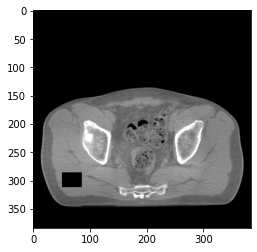

In [30]:
plt.imshow(x.squeeze(), 'gray'),

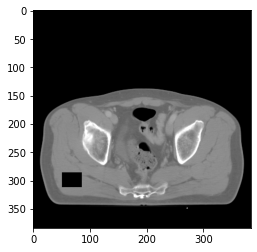

In [31]:
plt.imshow(y.squeeze(), 'gray')

In [32]:
x.shape, y.shape

((1, 384, 384), (1, 384, 384))

# training

In [33]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH, shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH, shuffle=False, num_workers=4)

In [34]:
import segmentation_models_pytorch as smp
import torchvision.models as models

model = smp.Unet(encoder_name=ENCODER, 
                  encoder_weights=ENCODER_WEIGHT, 
                  in_channels=GEN_IN_CHANNELS, 
                  classes=GEN_N_CLASSES,
                 decoder_attention_type=DECODER_ATT)

replace_relu_to_leakyReLU(model)
replace_bn_to_instanceNorm(model)

In [35]:
tf_discriminator = Discriminator(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)
replace_relu_to_leakyReLU(tf_discriminator)
replace_bn_to_instanceNorm(tf_discriminator)

In [36]:
edge_discriminator = Discriminator(in_channel=E_IN_CHANNELS, n_classes=E_N_CLASSES, activation=E_ACT)
replace_relu_to_leakyReLU(edge_discriminator)
replace_bn_to_instanceNorm(edge_discriminator)

In [37]:
edge_discriminator

Discriminator(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu): LeakyReLU(negative_slope=0.01)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (relu): LeakyReLU(negative_slope=0.01)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): InstanceNor

In [38]:
from codes.optimizer import Optimizer
# optimizer = optim.SGD(model.parameters(), lr=init_lr, momentum=momentum)
gen_optimizer = Optimizer(model.parameters(), name=GEN_OPTIM_NAME, lr=GEN_init_lr)
tf_dis_optimizer = Optimizer(tf_discriminator.parameters(), name=DIS_OPTIM_NAME, lr=DIS_init_lr)
edge_dis_optimizer = Optimizer(edge_discriminator.parameters(), name=E_OPTIM_NAME, lr=E_init_lr)

In [39]:
from codes.scheduler import Scheduler
tf_scheduler = Scheduler(tf_dis_optimizer, name=DIS_scheduler, T_0=10, T_mult=2)
edge_scheduler = Scheduler(edge_dis_optimizer, name=E_scheduler, T_0=10, T_mult=2)

In [40]:
import wandb

wandb.init(project="cbct_gan", config={
    "data": {
        "batchsize": BATCH,
    },
    "epochs": EPOCH,
    "model": {
        "in_channels": GEN_IN_CHANNELS,
        "out_channels": GEN_N_CLASSES,
        "optimizer": GEN_OPTIM_NAME,
        "init_lr": GEN_init_lr,
        "momentum": GEN_momentum,
        "encoder": ENCODER,
        "encoder_weight": ENCODER_WEIGHT,
        "activation": GEN_ACT,
        "decoder_attention_type": DECODER_ATT
    },
    "discriminator": {
        "in_channels": DIS_IN_CHANNELS,
        "out_channels": DIS_N_CLASSES,
        "optimizer": DIS_OPTIM_NAME,
        "init_lr": DIS_init_lr,
        "momentum": DIS_momentum,
        "encoder": "resnet34"
    }
})

wandb: Currently logged in as: junjun (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [41]:
wandb.watch(model)
wandb.watch(tf_discriminator)
wandb.watch(edge_discriminator)

max_score = 0

for epoch in range(EPOCH):
        
        loss_air, loss_bone, loss_edge_gen, loss_tf_gen, loss_edge_dis, loss_tf_dis, tf_lr, edge_lr = train_a2b_epoch(epoch, model, gen_optimizer, 
                                                                                             tf_discriminator, tf_dis_optimizer, tf_scheduler, 
                                                                                             edge_discriminator, edge_dis_optimizer, edge_scheduler,
                                                                                             trainloader, device)
        
        score_ssim_train, score_psnr_train, score_snr_train, score_mae_train, \
            score_air_train, score_bone_train, score_cont_train, score_tf_acc_train, score_edge_acc_train = eval_epoch(model, tf_discriminator, edge_discriminator, trainloader, device)
        
        score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, \
            score_air_test, score_bone_test, score_cont_test, score_tf_acc_test, score_edge_acc_test = eval_epoch(model, tf_discriminator, edge_discriminator, testloader, device)

        wandb.log({
            "lr scheduler tf": tf_lr,
            "lr scheduler edge": edge_lr,
            
            "loss mask": loss_air,
            "loss bone": loss_bone,
            "loss gen": loss_tf_gen,
            "loss dis": loss_tf_dis,
            "loss edge gen": loss_edge_gen,
            "loss edge dis": loss_edge_dis,
            
            "trainset cont score": score_cont_train,
            "trainset ssim score": score_ssim_train,
            "trainset psnr score": score_psnr_train,
            "trainset mae error": score_mae_train,
            "trainset snr score": score_snr_train,
            "trainset mask score": score_air_train,
            "trainset bone score": score_bone_train,
            "trainset acc score": score_tf_acc_train,
            "trainset edge acc score": score_edge_acc_train,
            
            "testset cont score": score_cont_test,
            "testset mae error": score_mae_test,
            "testset ssim score": score_ssim_test,
            "testset psnr score": score_psnr_test,
            "testset snr score": score_snr_test,
            "testset mask score": score_air_test,
            "testset bone score": score_bone_test,
            "testset acc score": score_tf_acc_test,
            "testset edge acc score": score_edge_acc_test
        })
        
        
        if score_air_test +  score_bone_test + score_snr_test >= max_score:
            max_score = score_air_test +  score_bone_test + score_snr_test
            checkpoint = {
                "model": model.state_dict(),
                "optimizer": gen_optimizer.state_dict(),
                "tf_discriminator": tf_discriminator.state_dict(),
                "tf_dis_optimizer": tf_dis_optimizer.state_dict(),
                "tf_scheduler": tf_scheduler.state_dict(),
                "edge_discriminator": edge_discriminator.state_dict(),
                "edge_dis_optimizer": edge_dis_optimizer.state_dict(),
                "edge_scheduler": edge_scheduler.state_dict()
            }
            torch.save(checkpoint, os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

168it [01:30,  1.85it/s]
168it [02:50,  1.02s/it]
168it [01:06,  2.54it/s]
24it [00:09,  2.49it/s]
168it [01:14,  2.25it/s]
168it [02:41,  1.04it/s]
168it [01:00,  2.80it/s]
24it [00:09,  2.49it/s]
168it [01:23,  2.01it/s]
168it [02:51,  1.02s/it]
168it [01:06,  2.54it/s]
24it [00:09,  2.44it/s]
168it [01:23,  2.01it/s]
168it [02:45,  1.02it/s]
168it [00:57,  2.94it/s]
24it [00:08,  2.80it/s]
168it [01:16,  2.20it/s]
168it [02:48,  1.00s/it]
168it [01:06,  2.54it/s]
24it [00:09,  2.45it/s]
168it [01:27,  1.93it/s]
168it [02:48,  1.00s/it]
168it [00:56,  2.97it/s]
24it [00:08,  2.82it/s]
168it [01:15,  2.22it/s]
168it [02:46,  1.01it/s]
168it [01:03,  2.65it/s]
24it [00:09,  2.44it/s]
168it [01:26,  1.94it/s]
168it [02:52,  1.03s/it]
168it [01:02,  2.67it/s]
24it [00:08,  2.86it/s]
168it [01:15,  2.22it/s]
168it [02:41,  1.04it/s]
168it [01:03,  2.66it/s]
24it [00:09,  2.51it/s]
168it [01:22,  2.04it/s]
168it [03:02,  1.09s/it]
168it [01:05,  2.55it/s]
24it [00:09,  2.45it/s]
168it [01:

In [42]:
checkpoint = torch.load(os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

In [43]:
model = smp.Unet(encoder_name=ENCODER, 
                  encoder_weights=ENCODER_WEIGHT, 
                  in_channels=GEN_IN_CHANNELS, 
                  classes=GEN_N_CLASSES,
                 decoder_attention_type=DECODER_ATT)
replace_relu_to_leakyReLU(model)
replace_bn_to_instanceNorm(model)
model.load_state_dict(checkpoint["model"])

<All keys matched successfully>

In [44]:
os.mkdir(os.path.join("eval-gan", wandb.run.name))

0it [00:00, ?it/s]

ssim score = 0.8724727630615234
psnr score = 25.91183853149414
snr score = 15.974775314331055
mae error = 0.016322335228323936
air dice score = 0.9934488338134956
bone dice score = 0.9170009256415149
contour dice score = 0.44112372398376465


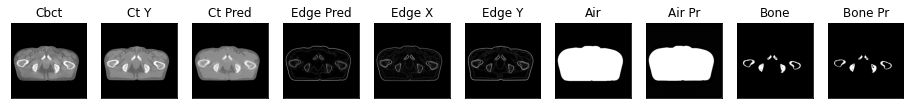

1it [00:00,  1.36it/s]

ssim score = 0.8723324537277222
psnr score = 25.79974937438965
snr score = 15.910221099853516
mae error = 0.016785187646746635
air dice score = 0.9931061689432485
bone dice score = 0.9168594786377162
contour dice score = 0.443379282951355


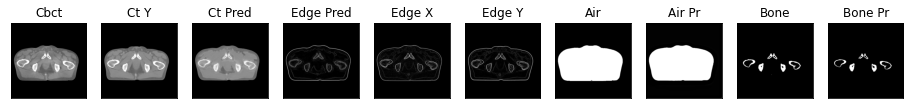

2it [00:01,  1.52it/s]

ssim score = 0.8750967979431152
psnr score = 25.737552642822266
snr score = 16.010921478271484
mae error = 0.01719002053141594
air dice score = 0.99363798664471
bone dice score = 0.887297798993804
contour dice score = 0.4616307020187378


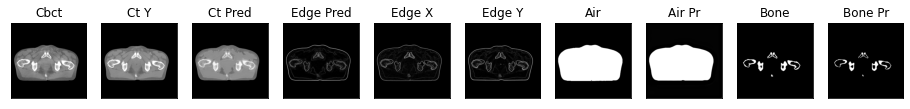

3it [00:01,  1.65it/s]

ssim score = 0.8728803396224976
psnr score = 25.665958404541016
snr score = 16.028579711914062
mae error = 0.01778274215757847
air dice score = 0.9937739652923333
bone dice score = 0.8496379035246148
contour dice score = 0.44777911901474


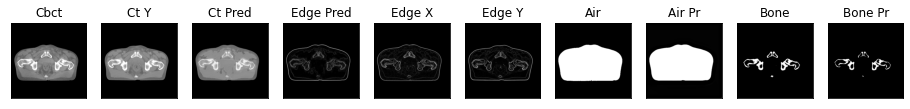

4it [00:02,  1.77it/s]

ssim score = 0.8727047443389893
psnr score = 25.734275817871094
snr score = 16.1372013092041
mae error = 0.017739910632371902
air dice score = 0.994279936157352
bone dice score = 0.8090222120470686
contour dice score = 0.44431066513061523


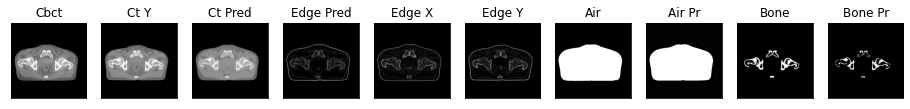

5it [00:02,  1.86it/s]

ssim score = 0.8715589046478271
psnr score = 25.539541244506836
snr score = 16.078998565673828
mae error = 0.018564458936452866
air dice score = 0.9944726070372233
bone dice score = 0.7553439367869987
contour dice score = 0.46710923314094543


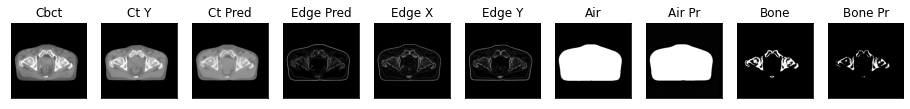

6it [00:03,  1.91it/s]

ssim score = 0.8684704303741455
psnr score = 25.342912673950195
snr score = 15.858314514160156
mae error = 0.018552429974079132
air dice score = 0.9942275314679766
bone dice score = 0.7598684210549548
contour dice score = 0.46973365545272827


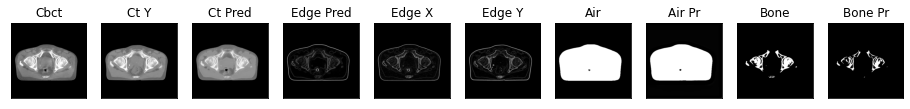

7it [00:03,  1.62it/s]

ssim score = 0.8718239068984985
psnr score = 25.926986694335938
snr score = 16.25684928894043
mae error = 0.01682191528379917
air dice score = 0.9937845651714092
bone dice score = 0.8291750503035294
contour dice score = 0.44930174946784973


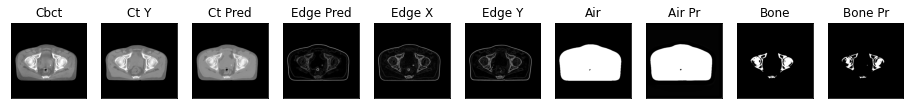

8it [00:04,  1.72it/s]

ssim score = 0.8746742010116577
psnr score = 26.414213180541992
snr score = 16.64952278137207
mae error = 0.016002370044589043
air dice score = 0.9938813136941124
bone dice score = 0.8836965632870526
contour dice score = 0.4665042757987976


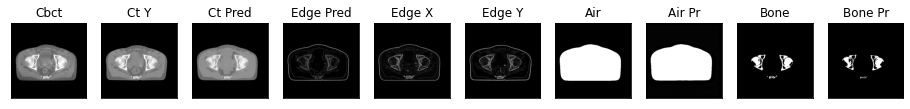

9it [00:04,  1.82it/s]

ssim score = 0.8757196068763733
psnr score = 26.309907913208008
snr score = 16.529935836791992
mae error = 0.015991266816854477
air dice score = 0.9933601917486936
bone dice score = 0.8809549885020155
contour dice score = 0.43101343512535095


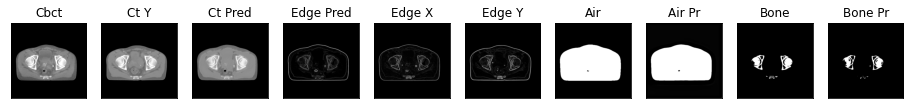

10it [00:05,  1.92it/s]

ssim score = 0.8820460438728333
psnr score = 26.729677200317383
snr score = 16.98197364807129
mae error = 0.015162274241447449
air dice score = 0.9929131839392924
bone dice score = 0.9069767441871068
contour dice score = 0.4498777389526367


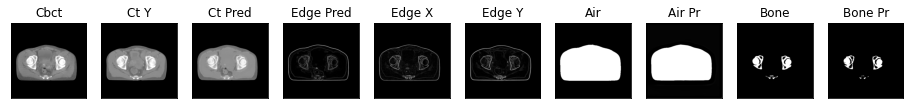

11it [00:05,  2.00it/s]

ssim score = 0.8828756213188171
psnr score = 25.75411605834961
snr score = 16.03012466430664
mae error = 0.016229867935180664
air dice score = 0.9923387138577091
bone dice score = 0.9117108874667004
contour dice score = 0.45315369963645935


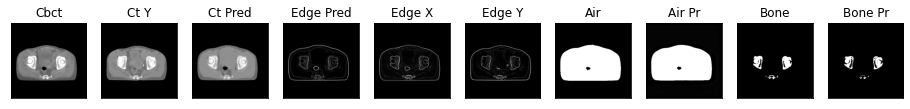

12it [00:06,  2.04it/s]

ssim score = 0.8843384385108948
psnr score = 25.070066452026367
snr score = 15.3141508102417
mae error = 0.01693115383386612
air dice score = 0.9915961103193985
bone dice score = 0.9247728649312564
contour dice score = 0.43680980801582336


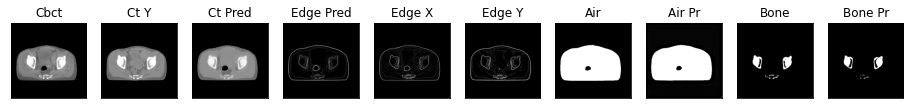

13it [00:06,  2.05it/s]

ssim score = 0.8829448819160461
psnr score = 24.93158531188965
snr score = 15.033714294433594
mae error = 0.016606442630290985
air dice score = 0.9918230223123818
bone dice score = 0.9083465398849928
contour dice score = 0.45089560747146606


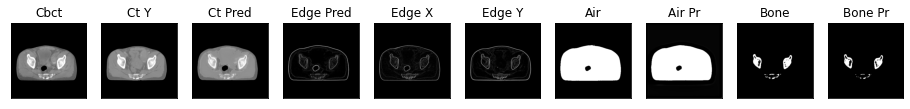

14it [00:07,  2.05it/s]

ssim score = 0.8780308961868286
psnr score = 24.741111755371094
snr score = 14.757577896118164
mae error = 0.017297331243753433
air dice score = 0.9924799252241232
bone dice score = 0.9116991643466337
contour dice score = 0.45089560747146606


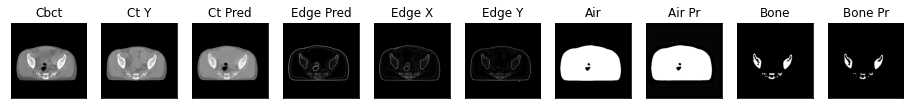

15it [00:07,  2.05it/s]

ssim score = 0.872461199760437
psnr score = 24.433841705322266
snr score = 14.473791122436523
mae error = 0.018563877791166306
air dice score = 0.9928837030388588
bone dice score = 0.9007015650310213
contour dice score = 0.4398496150970459


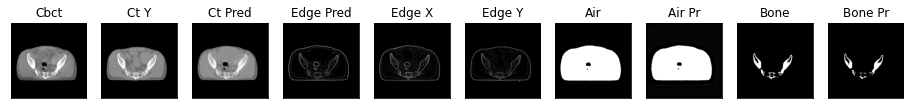

16it [00:08,  2.02it/s]

ssim score = 0.8678203821182251
psnr score = 23.609922409057617
snr score = 13.64732837677002
mae error = 0.02045905403792858
air dice score = 0.9926499200138433
bone dice score = 0.8909302626485841
contour dice score = 0.43494656682014465


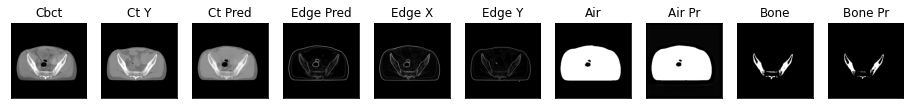

17it [00:08,  1.82it/s]

ssim score = 0.8604183197021484
psnr score = 23.00677490234375
snr score = 12.942422866821289
mae error = 0.02197372354567051
air dice score = 0.9911516025431046
bone dice score = 0.880721946117176
contour dice score = 0.41439205408096313


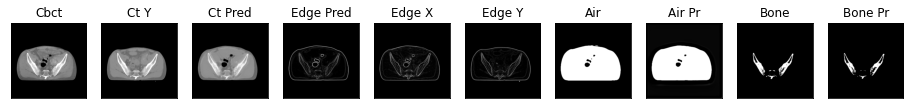

18it [00:09,  1.95it/s]

ssim score = 0.8575419783592224
psnr score = 22.689123153686523
snr score = 12.574089050292969
mae error = 0.02284931018948555
air dice score = 0.9903703296098714
bone dice score = 0.8636184986261808
contour dice score = 0.426564484834671


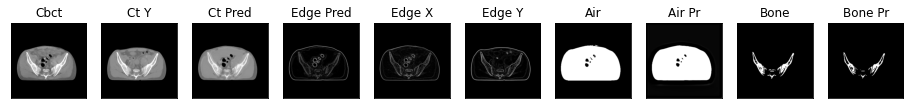

19it [00:09,  2.08it/s]

ssim score = 0.8598055243492126
psnr score = 22.69626808166504
snr score = 12.568922996520996
mae error = 0.022826634347438812
air dice score = 0.9907270974818134
bone dice score = 0.8541695193775959
contour dice score = 0.4241269826889038


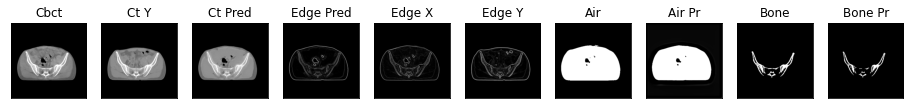

20it [00:10,  2.10it/s]

ssim score = 0.8576419353485107
psnr score = 22.61773109436035
snr score = 12.425539016723633
mae error = 0.022723188623785973
air dice score = 0.9905609734275851
bone dice score = 0.8504007123797803
contour dice score = 0.361770361661911


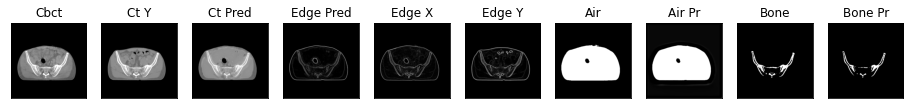

21it [00:10,  2.24it/s]

ssim score = 0.8523510098457336
psnr score = 22.588199615478516
snr score = 12.336579322814941
mae error = 0.022608760744333267
air dice score = 0.9900361401020141
bone dice score = 0.8609098811958721
contour dice score = 0.35506778955459595


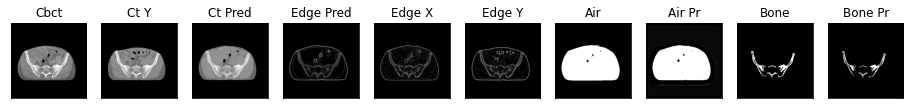

22it [00:11,  2.14it/s]

ssim score = 0.8572028279304504
psnr score = 22.69886016845703
snr score = 12.413810729980469
mae error = 0.022463710978627205
air dice score = 0.9911961417717011
bone dice score = 0.8525535420119089
contour dice score = 0.33896103501319885


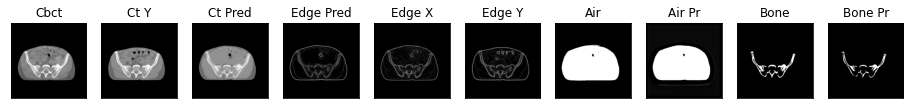

23it [00:11,  2.16it/s]

ssim score = 0.8559757471084595
psnr score = 22.622028350830078
snr score = 12.288414001464844
mae error = 0.02275083214044571
air dice score = 0.9914329681435133
bone dice score = 0.8433992517391314
contour dice score = 0.3538767397403717


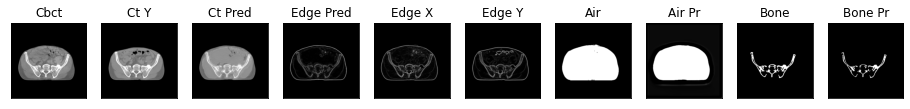

24it [00:12,  2.16it/s]

ssim score = 0.8557568192481995
psnr score = 22.39553451538086
snr score = 11.964921951293945
mae error = 0.023190388455986977
air dice score = 0.9908064459747722
bone dice score = 0.8440647711354831
contour dice score = 0.375


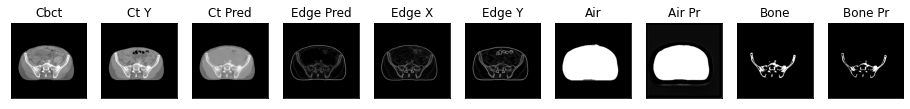

25it [00:12,  2.15it/s]

ssim score = 0.8555687069892883
psnr score = 22.496746063232422
snr score = 11.9833984375
mae error = 0.023277677595615387
air dice score = 0.9905123790298753
bone dice score = 0.8242844307556888
contour dice score = 0.3839346468448639


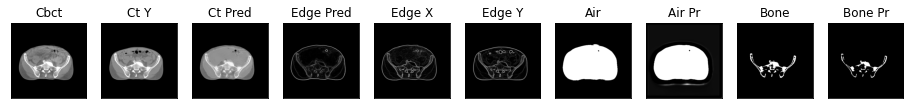

26it [00:13,  2.12it/s]

ssim score = 0.8542863726615906
psnr score = 22.512046813964844
snr score = 11.907512664794922
mae error = 0.02377822808921337
air dice score = 0.9851379019631638
bone dice score = 0.8234099276396672
contour dice score = 0.4225941300392151


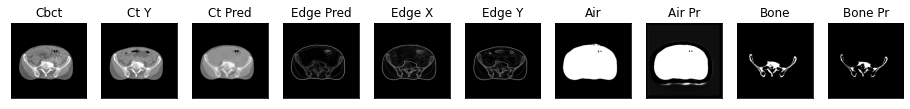

27it [00:13,  1.79it/s]

ssim score = 0.852240264415741
psnr score = 22.413162231445312
snr score = 11.767522811889648
mae error = 0.024053046479821205
air dice score = 0.9829256699938053
bone dice score = 0.8345891639775793
contour dice score = 0.4113074243068695


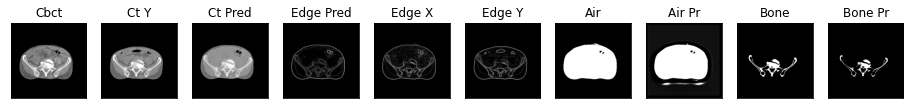

28it [00:14,  1.91it/s]

ssim score = 0.850522518157959
psnr score = 23.551620483398438
snr score = 14.923778533935547
mae error = 0.024135233834385872
air dice score = 0.9930391547545102
bone dice score = 0.9334521687482634
contour dice score = 0.1746910959482193


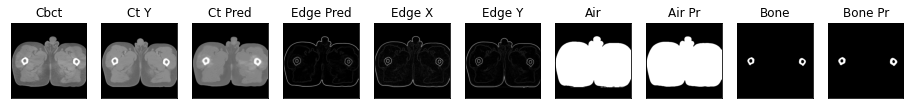

29it [00:14,  1.97it/s]

ssim score = 0.8547256588935852
psnr score = 24.046714782714844
snr score = 15.458130836486816
mae error = 0.023046202957630157
air dice score = 0.992200341042709
bone dice score = 0.9376391982199989
contour dice score = 0.19172297418117523


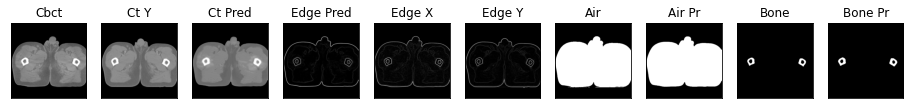

30it [00:15,  1.99it/s]

ssim score = 0.8619429469108582
psnr score = 24.705965042114258
snr score = 16.204830169677734
mae error = 0.022543692961335182
air dice score = 0.9924136371138856
bone dice score = 0.9437751004028608
contour dice score = 0.18424566090106964


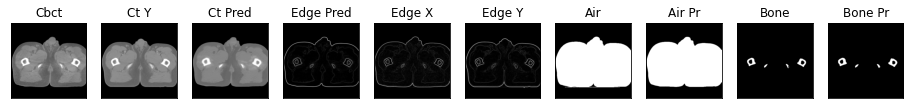

31it [00:15,  2.02it/s]

ssim score = 0.8666083216667175
psnr score = 25.078107833862305
snr score = 16.73952865600586
mae error = 0.023452021181583405
air dice score = 0.9929049555875797
bone dice score = 0.9590625000006396
contour dice score = 0.18215271830558777


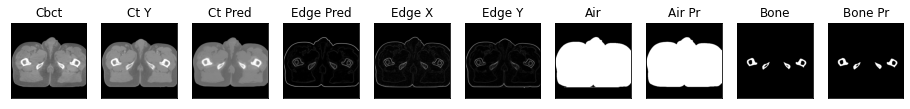

32it [00:16,  2.11it/s]

ssim score = 0.8621531128883362
psnr score = 25.21564292907715
snr score = 17.005205154418945
mae error = 0.02423919551074505
air dice score = 0.9926682044668903
bone dice score = 0.9460387203083065
contour dice score = 0.17868776619434357


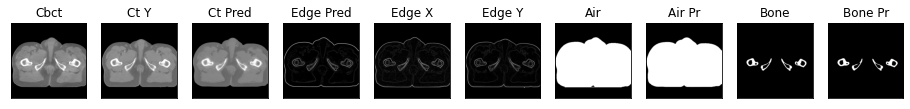

33it [00:16,  2.17it/s]

ssim score = 0.861187756061554
psnr score = 25.53672981262207
snr score = 17.42953109741211
mae error = 0.024476204067468643
air dice score = 0.9927802406586491
bone dice score = 0.9357326478156968
contour dice score = 0.1797020435333252


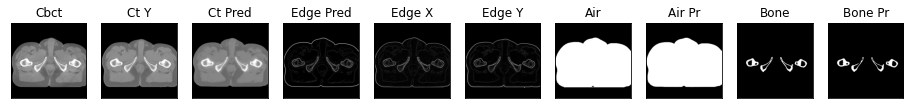

34it [00:16,  2.23it/s]

ssim score = 0.8609156012535095
psnr score = 25.82191276550293
snr score = 17.781814575195312
mae error = 0.024584757164120674
air dice score = 0.9926700312424942
bone dice score = 0.9235487901860325
contour dice score = 0.16845044493675232


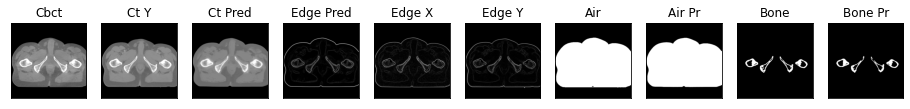

35it [00:17,  2.33it/s]

ssim score = 0.8572045564651489
psnr score = 25.9689998626709
snr score = 17.919010162353516
mae error = 0.024354279041290283
air dice score = 0.992666530861687
bone dice score = 0.9340540540547669
contour dice score = 0.17354989051818848


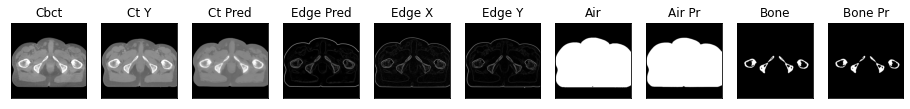

36it [00:17,  2.41it/s]

ssim score = 0.8560603857040405
psnr score = 26.098560333251953
snr score = 18.034910202026367
mae error = 0.024274196475744247
air dice score = 0.9928213220482885
bone dice score = 0.9421558164360496
contour dice score = 0.16512058675289154


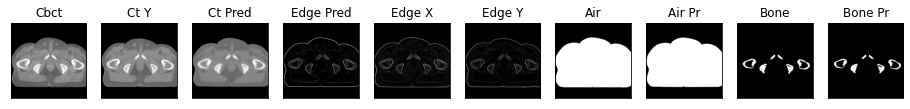

37it [00:19,  1.29it/s]

ssim score = 0.8634358048439026
psnr score = 26.471160888671875
snr score = 18.419511795043945
mae error = 0.023667752742767334
air dice score = 0.9928353076041312
bone dice score = 0.9377248201445849
contour dice score = 0.16914498805999756


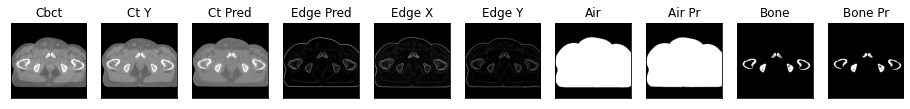

38it [00:19,  1.48it/s]

ssim score = 0.8663105368614197
psnr score = 26.457441329956055
snr score = 18.444873809814453
mae error = 0.023955954238772392
air dice score = 0.9928261077158179
bone dice score = 0.9323694029858631
contour dice score = 0.16402609646320343


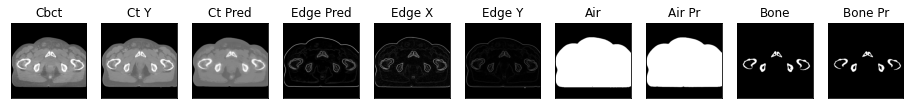

39it [00:20,  1.64it/s]

ssim score = 0.8607286214828491
psnr score = 26.221572875976562
snr score = 18.350296020507812
mae error = 0.02540597692131996
air dice score = 0.9931433686409111
bone dice score = 0.9021716649441347
contour dice score = 0.16190922260284424


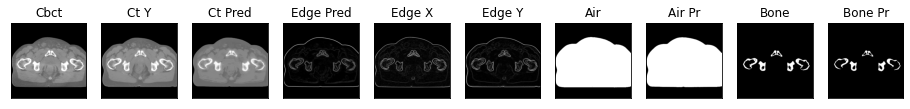

40it [00:20,  1.83it/s]

ssim score = 0.8521799445152283
psnr score = 25.650890350341797
snr score = 17.874300003051758
mae error = 0.02800193428993225
air dice score = 0.993237673090483
bone dice score = 0.8639401229629873
contour dice score = 0.16861826181411743


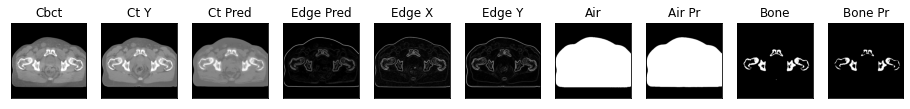

41it [00:21,  1.96it/s]

ssim score = 0.8415247797966003
psnr score = 24.849641799926758
snr score = 17.039005279541016
mae error = 0.028910206630825996
air dice score = 0.9931848015680392
bone dice score = 0.8036571014772911
contour dice score = 0.1764429807662964


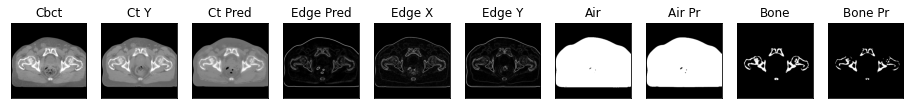

42it [00:21,  2.04it/s]

ssim score = 0.8376672267913818
psnr score = 23.77337646484375
snr score = 16.034927368164062
mae error = 0.03181181475520134
air dice score = 0.9925684642297065
bone dice score = 0.7351386517058215
contour dice score = 0.1836158186197281


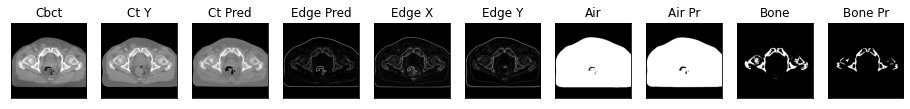

43it [00:21,  2.10it/s]

ssim score = 0.8428288698196411
psnr score = 24.266489028930664
snr score = 16.391942977905273
mae error = 0.029046092182397842
air dice score = 0.9930034377572308
bone dice score = 0.787268331992473
contour dice score = 0.19933868944644928


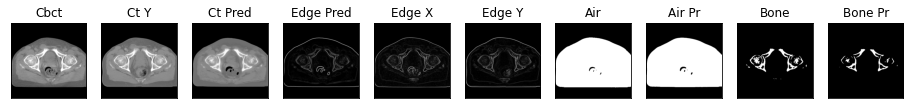

44it [00:22,  2.15it/s]

ssim score = 0.851458728313446
psnr score = 24.8270320892334
snr score = 16.77392578125
mae error = 0.026401499286293983
air dice score = 0.9932220462502848
bone dice score = 0.8369296833082455
contour dice score = 0.20293977856636047


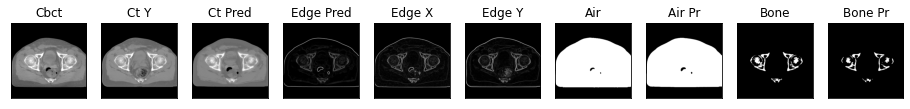

45it [00:22,  2.25it/s]

ssim score = 0.8505362868309021
psnr score = 25.206518173217773
snr score = 17.062824249267578
mae error = 0.02567611075937748
air dice score = 0.9937187150702278
bone dice score = 0.8541739638078905
contour dice score = 0.20847216248512268


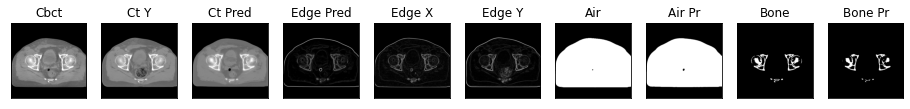

46it [00:23,  2.27it/s]

ssim score = 0.8565031886100769
psnr score = 25.343643188476562
snr score = 17.21563720703125
mae error = 0.02514464780688286
air dice score = 0.9944446138366347
bone dice score = 0.8712698758454446
contour dice score = 0.2260371893644333


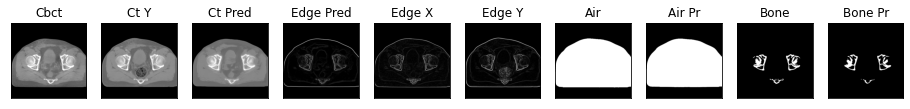

47it [00:23,  1.95it/s]

ssim score = 0.8464803099632263
psnr score = 25.170135498046875
snr score = 17.052165985107422
mae error = 0.025739405304193497
air dice score = 0.9944042314552097
bone dice score = 0.8529886914392872
contour dice score = 0.24332061409950256


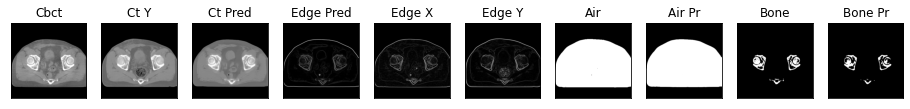

48it [00:24,  2.04it/s]

ssim score = 0.8531724214553833
psnr score = 25.29061508178711
snr score = 17.234235763549805
mae error = 0.02587040327489376
air dice score = 0.994434570846994
bone dice score = 0.8633977216457316
contour dice score = 0.24152745306491852


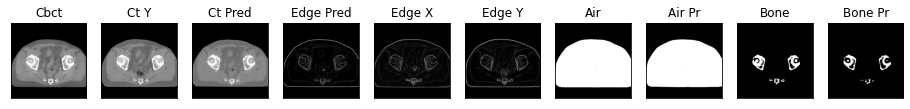

49it [00:24,  2.14it/s]

ssim score = 0.8527352809906006
psnr score = 25.550851821899414
snr score = 17.564552307128906
mae error = 0.026284627616405487
air dice score = 0.9941446216809287
bone dice score = 0.9105326989466318
contour dice score = 0.24118207395076752


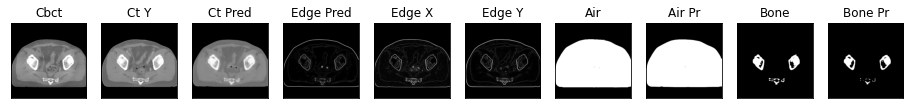

50it [00:25,  2.20it/s]

ssim score = 0.8561761379241943
psnr score = 25.62076759338379
snr score = 17.515363693237305
mae error = 0.025353144854307175
air dice score = 0.9938280358849501
bone dice score = 0.9014727235023702
contour dice score = 0.22391614317893982


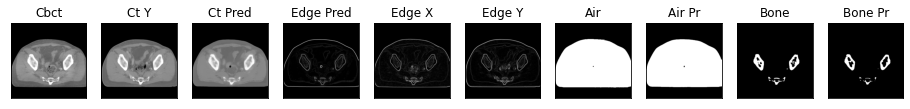

51it [00:25,  2.23it/s]

ssim score = 0.8463305234909058
psnr score = 24.83670425415039
snr score = 16.812931060791016
mae error = 0.027843356132507324
air dice score = 0.9933620546197552
bone dice score = 0.8927626175057701
contour dice score = 0.20019157230854034


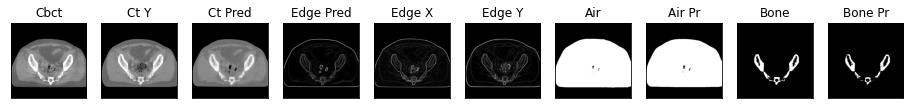

52it [00:26,  2.24it/s]

ssim score = 0.845027506351471
psnr score = 24.726402282714844
snr score = 16.78277587890625
mae error = 0.029047565534710884
air dice score = 0.9924304897411643
bone dice score = 0.8529994452820905
contour dice score = 0.18164344131946564


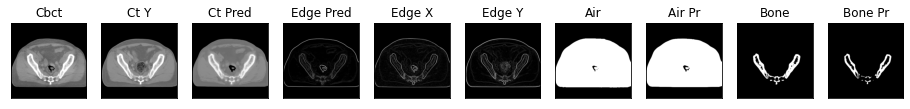

53it [00:26,  2.30it/s]

ssim score = 0.8271515965461731
psnr score = 24.24227523803711
snr score = 16.32020378112793
mae error = 0.030266636982560158
air dice score = 0.9927446382754136
bone dice score = 0.8315516682877263
contour dice score = 0.1571841835975647


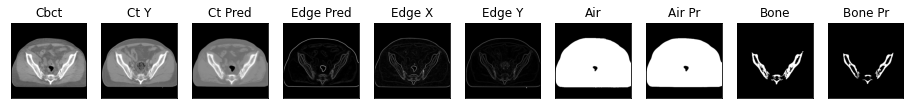

54it [00:26,  2.33it/s]

ssim score = 0.8312126398086548
psnr score = 24.90182876586914
snr score = 16.992298126220703
mae error = 0.029045382514595985
air dice score = 0.9927188603433625
bone dice score = 0.8373385646572067
contour dice score = 0.13269230723381042


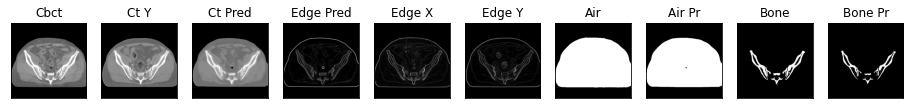

55it [00:27,  2.30it/s]

ssim score = 0.8123674392700195
psnr score = 21.231891632080078
snr score = 11.112100601196289
mae error = 0.03009234555065632
air dice score = 0.9960313203904358
bone dice score = 0.9433465085653927
contour dice score = 0.4853185713291168


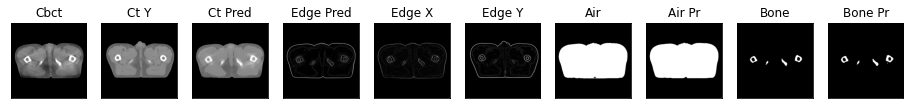

56it [00:27,  2.29it/s]

ssim score = 0.8026208281517029
psnr score = 20.993127822875977
snr score = 11.086316108703613
mae error = 0.03172238543629646
air dice score = 0.9961952849980477
bone dice score = 0.9207355738761206
contour dice score = 0.5046831965446472


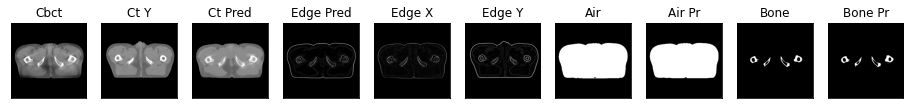

57it [00:28,  1.99it/s]

ssim score = 0.7990513443946838
psnr score = 21.086498260498047
snr score = 11.31082534790039
mae error = 0.031723275780677795
air dice score = 0.9962774000159194
bone dice score = 0.8966480446947995
contour dice score = 0.5129050016403198


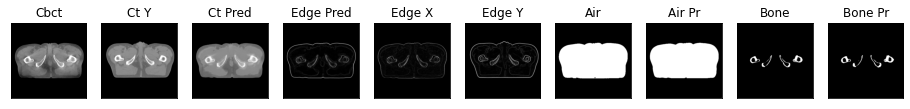

58it [00:28,  2.11it/s]

ssim score = 0.8008041977882385
psnr score = 21.36610984802246
snr score = 11.66083812713623
mae error = 0.030805855989456177
air dice score = 0.9952733450106105
bone dice score = 0.8909334866802582
contour dice score = 0.47671231627464294


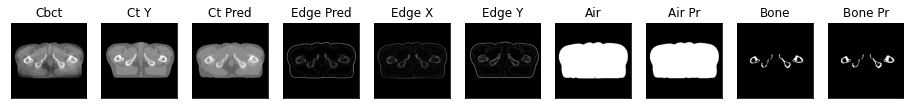

59it [00:29,  2.13it/s]

ssim score = 0.8021047711372375
psnr score = 21.45330238342285
snr score = 11.7955961227417
mae error = 0.030720075592398643
air dice score = 0.994840204285794
bone dice score = 0.9061801935981724
contour dice score = 0.47738420963287354


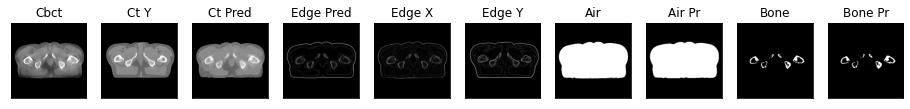

60it [00:29,  2.17it/s]

ssim score = 0.7997444272041321
psnr score = 21.539594650268555
snr score = 11.887507438659668
mae error = 0.030431969091296196
air dice score = 0.9945598936468002
bone dice score = 0.9134088417991705
contour dice score = 0.4872611463069916


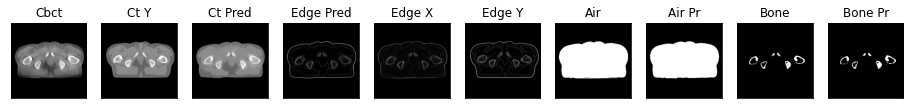

61it [00:30,  2.21it/s]

ssim score = 0.7980747222900391
psnr score = 21.523303985595703
snr score = 11.86471176147461
mae error = 0.03050411492586136
air dice score = 0.9939889899932876
bone dice score = 0.9124183006552303
contour dice score = 0.49787235260009766


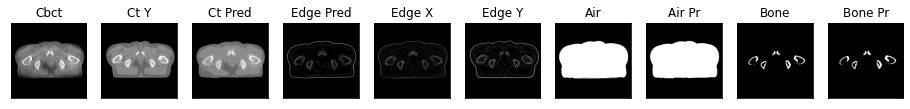

62it [00:30,  2.30it/s]

ssim score = 0.7987995147705078
psnr score = 21.39296531677246
snr score = 11.748485565185547
mae error = 0.030792471021413803
air dice score = 0.9937734798942589
bone dice score = 0.9192569431686729
contour dice score = 0.42317914962768555


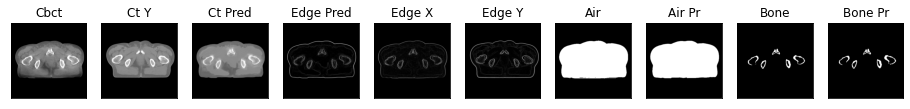

63it [00:30,  2.30it/s]

ssim score = 0.8006113171577454
psnr score = 21.350278854370117
snr score = 11.763805389404297
mae error = 0.03089062310755253
air dice score = 0.9947206640848908
bone dice score = 0.9040914361453687
contour dice score = 0.47354355454444885


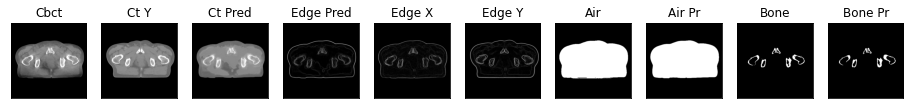

64it [00:31,  2.30it/s]

ssim score = 0.7957658171653748
psnr score = 21.248579025268555
snr score = 11.760664939880371
mae error = 0.03178906813263893
air dice score = 0.9946058270920866
bone dice score = 0.8958233317347444
contour dice score = 0.5002644062042236


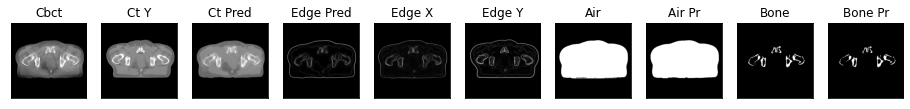

65it [00:31,  2.28it/s]

ssim score = 0.7851908802986145
psnr score = 21.114805221557617
snr score = 11.662720680236816
mae error = 0.03297339007258415
air dice score = 0.9941375851693061
bone dice score = 0.8757321513396275
contour dice score = 0.44324904680252075


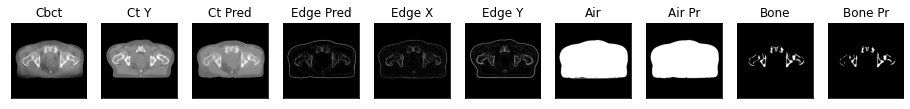

66it [00:32,  2.36it/s]

ssim score = 0.7738869190216064
psnr score = 21.019495010375977
snr score = 11.600113868713379
mae error = 0.034034449607133865
air dice score = 0.9946112128225546
bone dice score = 0.8319787202625687
contour dice score = 0.49517685174942017


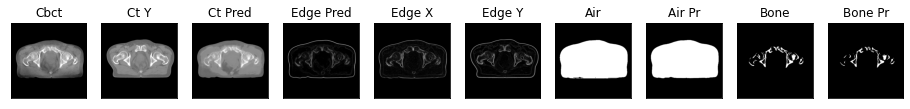

67it [00:32,  2.01it/s]

ssim score = 0.7752730846405029
psnr score = 21.105667114257812
snr score = 11.803106307983398
mae error = 0.033806487917900085
air dice score = 0.9949330594135514
bone dice score = 0.8817891373818337
contour dice score = 0.5203166007995605


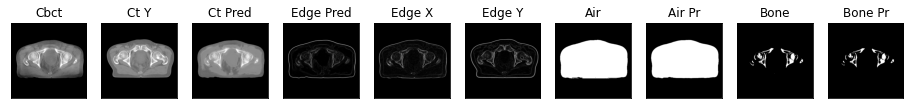

68it [00:33,  2.08it/s]

ssim score = 0.7801328301429749
psnr score = 21.0693359375
snr score = 11.750787734985352
mae error = 0.033783335238695145
air dice score = 0.9951677481706517
bone dice score = 0.8880242109830231
contour dice score = 0.5362398028373718


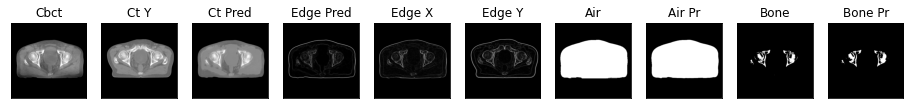

69it [00:33,  2.14it/s]

ssim score = 0.7952806949615479
psnr score = 21.60171890258789
snr score = 12.084007263183594
mae error = 0.03129866346716881
air dice score = 0.9949832775919776
bone dice score = 0.9063298752081442
contour dice score = 0.5526881814002991


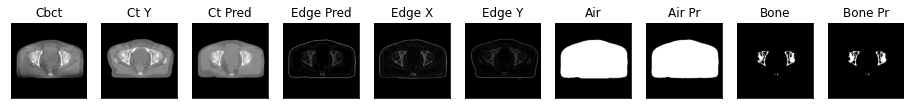

70it [00:34,  2.24it/s]

ssim score = 0.8100181818008423
psnr score = 22.26386070251465
snr score = 12.57575798034668
mae error = 0.028598351404070854
air dice score = 0.9948293513890247
bone dice score = 0.937656554412223
contour dice score = 0.5180398225784302


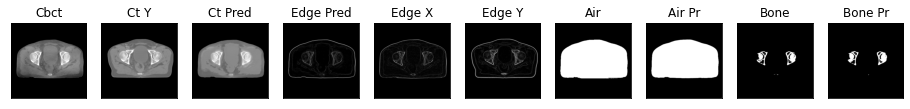

71it [00:34,  2.25it/s]

ssim score = 0.8158806562423706
psnr score = 22.657930374145508
snr score = 12.98399543762207
mae error = 0.02729790285229683
air dice score = 0.9951323369075358
bone dice score = 0.936345514951012
contour dice score = 0.5002672076225281


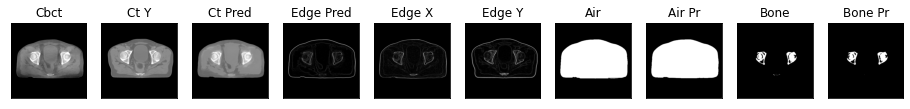

72it [00:35,  2.26it/s]

ssim score = 0.8208078742027283
psnr score = 22.887252807617188
snr score = 13.295145988464355
mae error = 0.02702810801565647
air dice score = 0.995263748404838
bone dice score = 0.9442560694433167
contour dice score = 0.5040738582611084


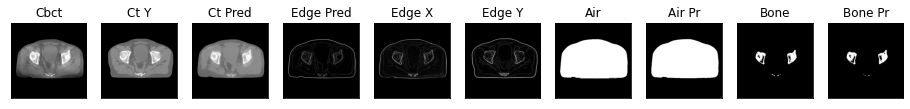

73it [00:35,  2.27it/s]

ssim score = 0.8223780989646912
psnr score = 22.88904571533203
snr score = 13.38911247253418
mae error = 0.02720334380865097
air dice score = 0.9954721752353654
bone dice score = 0.9311680572119909
contour dice score = 0.5201101899147034


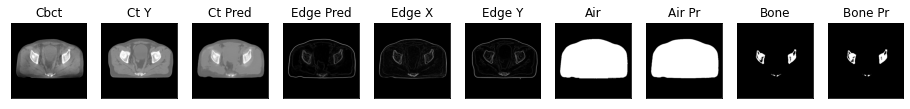

74it [00:35,  2.34it/s]

ssim score = 0.8190565705299377
psnr score = 23.227191925048828
snr score = 13.663827896118164
mae error = 0.026177549734711647
air dice score = 0.9954378319487986
bone dice score = 0.9492410641431493
contour dice score = 0.544283390045166


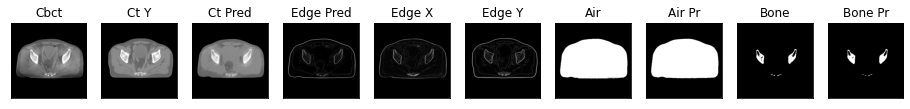

75it [00:36,  2.35it/s]

ssim score = 0.8174194693565369
psnr score = 23.30999755859375
snr score = 13.71024227142334
mae error = 0.02548941597342491
air dice score = 0.9945955147027579
bone dice score = 0.948695499913348
contour dice score = 0.49253731966018677


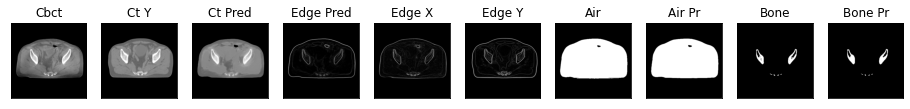

76it [00:36,  2.33it/s]

ssim score = 0.8123633861541748
psnr score = 23.081361770629883
snr score = 13.519352912902832
mae error = 0.026954542845487595
air dice score = 0.9945101243520716
bone dice score = 0.9311140408712737
contour dice score = 0.4853956401348114


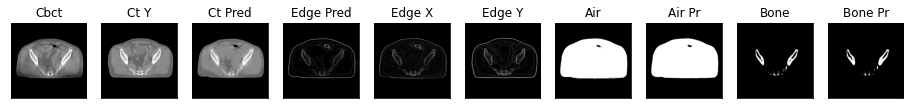

77it [00:37,  1.98it/s]

ssim score = 0.8052712678909302
psnr score = 22.939741134643555
snr score = 13.508235931396484
mae error = 0.027733776718378067
air dice score = 0.9946230603393227
bone dice score = 0.9211569519905864
contour dice score = 0.5144385099411011


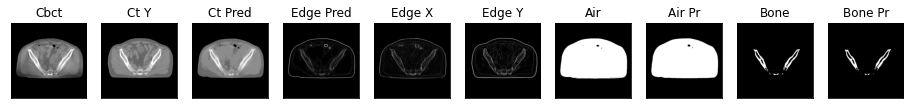

78it [00:37,  2.11it/s]

ssim score = 0.8090479373931885
psnr score = 22.780885696411133
snr score = 13.3671293258667
mae error = 0.028718534857034683
air dice score = 0.994437693611054
bone dice score = 0.8901472253698407
contour dice score = 0.4935483932495117


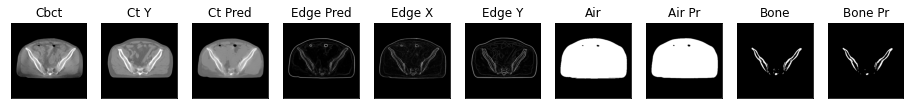

79it [00:38,  2.17it/s]

ssim score = 0.8113846778869629
psnr score = 23.22734832763672
snr score = 13.802323341369629
mae error = 0.027653023600578308
air dice score = 0.9945429389067019
bone dice score = 0.8974991194100476
contour dice score = 0.49648457765579224


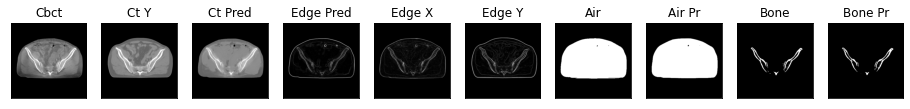

80it [00:38,  2.21it/s]

ssim score = 0.8162980079650879
psnr score = 23.3431453704834
snr score = 13.917379379272461
mae error = 0.026909785345196724
air dice score = 0.9944795224786992
bone dice score = 0.8809034907617915
contour dice score = 0.4721919298171997


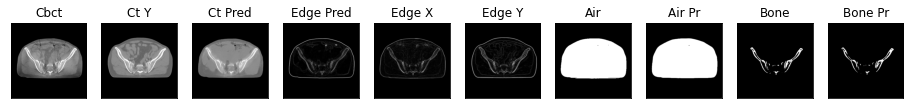

81it [00:39,  2.23it/s]

ssim score = 0.8440853357315063
psnr score = 23.777782440185547
snr score = 14.211917877197266
mae error = 0.021920112892985344
air dice score = 0.9941765255665752
bone dice score = 0.9032030975042871
contour dice score = 0.403191477060318


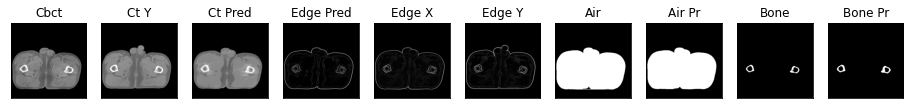

82it [00:39,  2.32it/s]

ssim score = 0.8474869728088379
psnr score = 24.13364601135254
snr score = 14.632172584533691
mae error = 0.02146112360060215
air dice score = 0.9933523417706491
bone dice score = 0.894652577653069
contour dice score = 0.3480546772480011


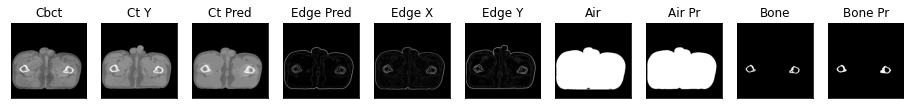

83it [00:39,  2.32it/s]

ssim score = 0.8572917580604553
psnr score = 25.588764190673828
snr score = 16.226503372192383
mae error = 0.019293254241347313
air dice score = 0.9936527886881432
bone dice score = 0.9150579150597371
contour dice score = 0.32382890582084656


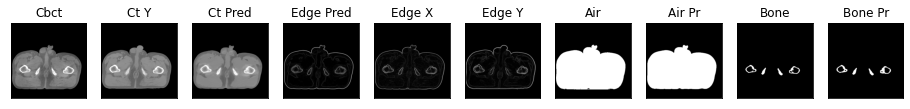

84it [00:40,  2.31it/s]

ssim score = 0.8548822999000549
psnr score = 25.62748908996582
snr score = 16.386720657348633
mae error = 0.019473310559988022
air dice score = 0.9940826552228236
bone dice score = 0.9052849740952272
contour dice score = 0.30927833914756775


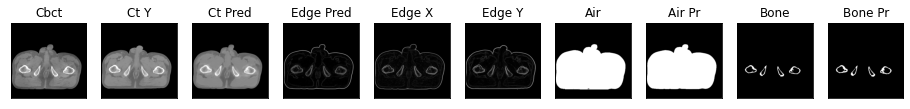

85it [00:40,  2.29it/s]

ssim score = 0.8506202101707458
psnr score = 25.537822723388672
snr score = 16.321224212646484
mae error = 0.019557243213057518
air dice score = 0.9942917745406951
bone dice score = 0.901986465839293
contour dice score = 0.3158441483974457


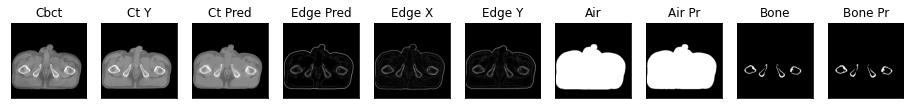

86it [00:41,  2.28it/s]

ssim score = 0.8495182991027832
psnr score = 25.362468719482422
snr score = 16.141475677490234
mae error = 0.019800284877419472
air dice score = 0.9943298647890878
bone dice score = 0.9025805161051694
contour dice score = 0.3184913694858551


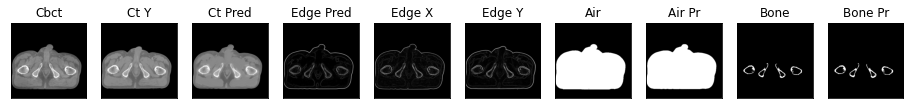

87it [00:41,  1.95it/s]

ssim score = 0.8457189798355103
psnr score = 24.870927810668945
snr score = 15.656187057495117
mae error = 0.02072356455028057
air dice score = 0.9943579327465627
bone dice score = 0.9039370078759067
contour dice score = 0.3046916127204895


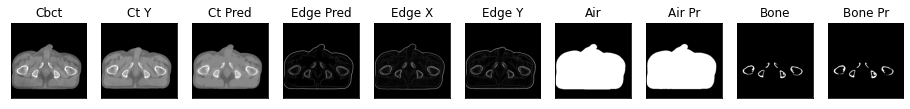

88it [00:42,  2.03it/s]

ssim score = 0.843424916267395
psnr score = 24.62529754638672
snr score = 15.38900375366211
mae error = 0.02095487341284752
air dice score = 0.9945633548306738
bone dice score = 0.9047807190852473
contour dice score = 0.32172995805740356


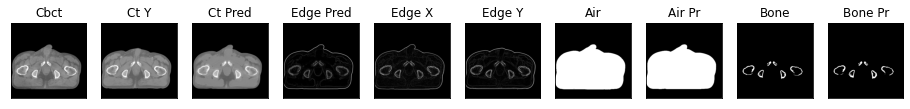

89it [00:42,  2.09it/s]

ssim score = 0.8471813797950745
psnr score = 24.65766716003418
snr score = 15.438283920288086
mae error = 0.020816750824451447
air dice score = 0.9945024051977303
bone dice score = 0.918683812406984
contour dice score = 0.30752915143966675


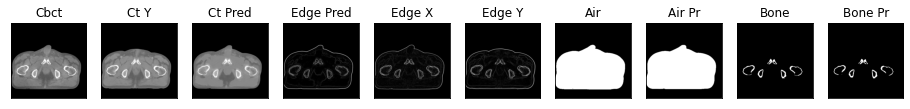

90it [00:43,  2.20it/s]

ssim score = 0.8488703966140747
psnr score = 25.027118682861328
snr score = 15.876327514648438
mae error = 0.02016131579875946
air dice score = 0.9948269375470319
bone dice score = 0.913202296052997
contour dice score = 0.3099946677684784


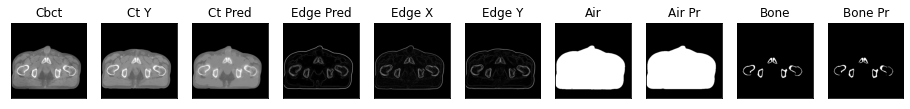

91it [00:43,  2.23it/s]

ssim score = 0.8459730744361877
psnr score = 25.403884887695312
snr score = 16.334453582763672
mae error = 0.019889138638973236
air dice score = 0.9949475871187121
bone dice score = 0.8963823866443545
contour dice score = 0.31182795763015747


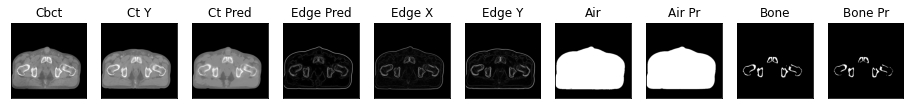

92it [00:44,  2.25it/s]

ssim score = 0.8476247787475586
psnr score = 25.65880584716797
snr score = 16.64007568359375
mae error = 0.019963882863521576
air dice score = 0.995147472576111
bone dice score = 0.8504961769993412
contour dice score = 0.3143164813518524


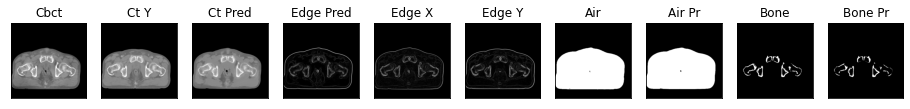

93it [00:44,  2.30it/s]

ssim score = 0.8501660227775574
psnr score = 25.940542221069336
snr score = 17.038082122802734
mae error = 0.020175166428089142
air dice score = 0.9950691273465285
bone dice score = 0.7892503536101013
contour dice score = 0.34356489777565


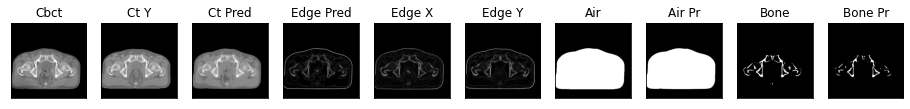

94it [00:44,  2.33it/s]

ssim score = 0.8489084243774414
psnr score = 25.448596954345703
snr score = 16.50790023803711
mae error = 0.02036118693649769
air dice score = 0.994842525647877
bone dice score = 0.7867186176556544
contour dice score = 0.3284868001937866


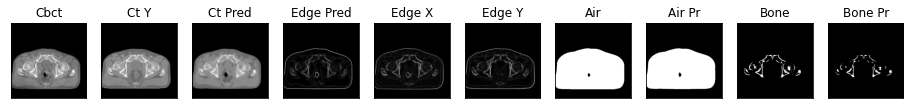

95it [00:45,  2.32it/s]

ssim score = 0.8442737460136414
psnr score = 24.689395904541016
snr score = 15.65302848815918
mae error = 0.020907176658511162
air dice score = 0.9935855183833628
bone dice score = 0.8168843000331478
contour dice score = 0.35567566752433777


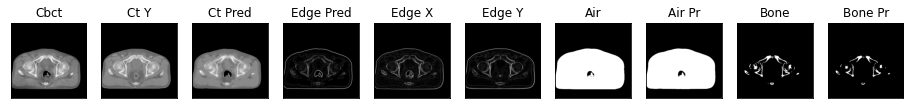

96it [00:45,  2.31it/s]

ssim score = 0.8479311466217041
psnr score = 24.476852416992188
snr score = 15.28072738647461
mae error = 0.020825626328587532
air dice score = 0.993306082803842
bone dice score = 0.8810996563594313
contour dice score = 0.37289974093437195


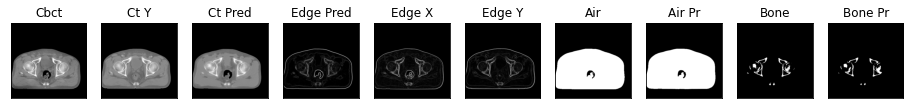

97it [00:46,  2.02it/s]

ssim score = 0.8458062410354614
psnr score = 24.129749298095703
snr score = 14.817198753356934
mae error = 0.021342366933822632
air dice score = 0.9929884559058203
bone dice score = 0.8790560471997387
contour dice score = 0.3701687455177307


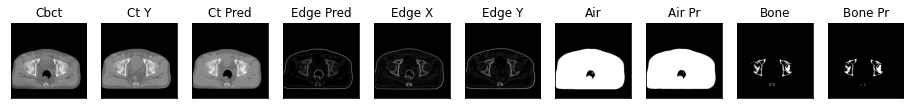

98it [00:46,  2.11it/s]

ssim score = 0.8444522619247437
psnr score = 23.998258590698242
snr score = 14.640612602233887
mae error = 0.021748574450612068
air dice score = 0.9931985112479882
bone dice score = 0.9062398965420911
contour dice score = 0.3893129825592041


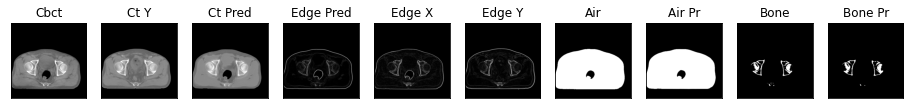

99it [00:47,  2.16it/s]

ssim score = 0.8402051329612732
psnr score = 23.451541900634766
snr score = 14.100570678710938
mae error = 0.022893065586686134
air dice score = 0.9933046389287478
bone dice score = 0.9218134034178415
contour dice score = 0.3923497200012207


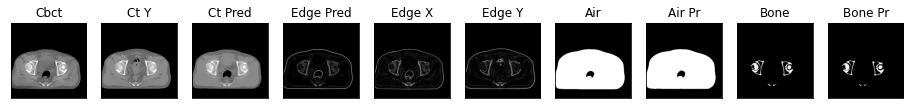

100it [00:47,  2.27it/s]

ssim score = 0.8435571789741516
psnr score = 23.113948822021484
snr score = 13.793079376220703
mae error = 0.02382812462747097
air dice score = 0.9937314690166139
bone dice score = 0.9256301863171187
contour dice score = 0.39759036898612976


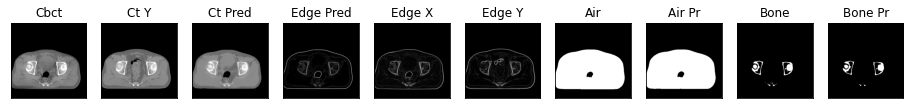

101it [00:48,  2.28it/s]

ssim score = 0.8506236672401428
psnr score = 23.73937225341797
snr score = 14.375917434692383
mae error = 0.0219303909689188
air dice score = 0.993294679455992
bone dice score = 0.9225762247358243
contour dice score = 0.37719297409057617


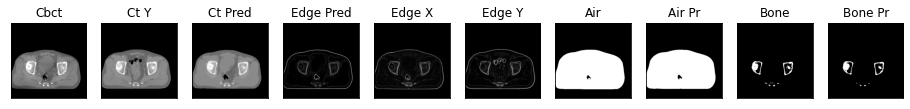

102it [00:48,  2.30it/s]

ssim score = 0.8501874804496765
psnr score = 23.916940689086914
snr score = 14.463281631469727
mae error = 0.021211126819252968
air dice score = 0.9938726504926771
bone dice score = 0.9232227488166214
contour dice score = 0.3660273849964142


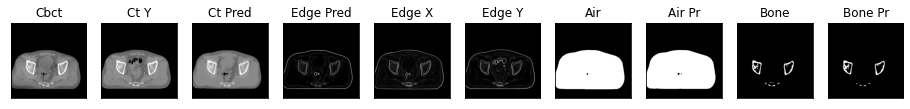

103it [00:49,  2.30it/s]

ssim score = 0.8498871922492981
psnr score = 23.620380401611328
snr score = 14.100997924804688
mae error = 0.021935496479272842
air dice score = 0.9941448072805188
bone dice score = 0.9330427892247812
contour dice score = 0.37932929396629333


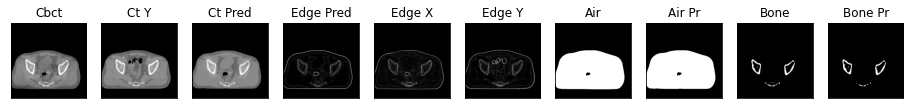

104it [00:49,  2.37it/s]

ssim score = 0.8440843224525452
psnr score = 23.709957122802734
snr score = 14.190271377563477
mae error = 0.022109074518084526
air dice score = 0.9940681822011812
bone dice score = 0.9246213455455332
contour dice score = 0.3647382855415344


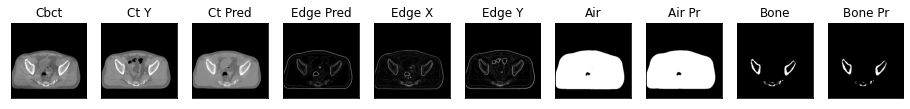

105it [00:49,  2.35it/s]

ssim score = 0.8397078514099121
psnr score = 23.577404022216797
snr score = 14.13388442993164
mae error = 0.023145461454987526
air dice score = 0.9939093894077868
bone dice score = 0.9033025885167614
contour dice score = 0.37299391627311707


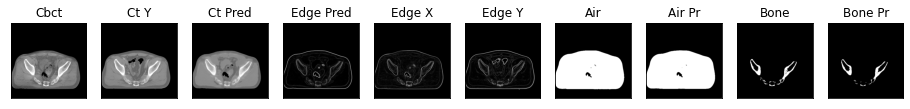

106it [00:50,  2.34it/s]

ssim score = 0.845635712146759
psnr score = 23.708534240722656
snr score = 14.3005952835083
mae error = 0.023035073652863503
air dice score = 0.9940672379696821
bone dice score = 0.8815206517095681
contour dice score = 0.35619470477104187


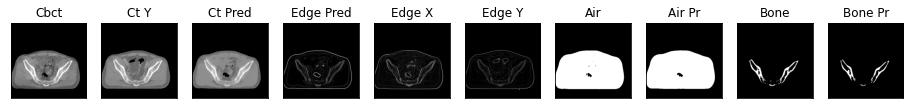

107it [00:50,  1.99it/s]

ssim score = 0.8468196988105774
psnr score = 24.311843872070312
snr score = 14.842206954956055
mae error = 0.021578947082161903
air dice score = 0.9944043663160118
bone dice score = 0.8725880551321197
contour dice score = 0.3466666638851166


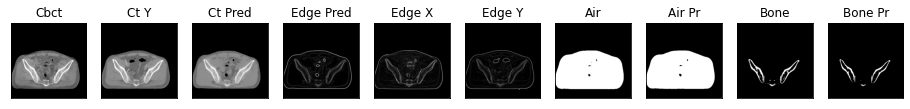

108it [00:51,  2.13it/s]

ssim score = 0.842413067817688
psnr score = 24.21222496032715
snr score = 14.681327819824219
mae error = 0.021892467513680458
air dice score = 0.9936011530079846
bone dice score = 0.8614183474323126
contour dice score = 0.30510374903678894


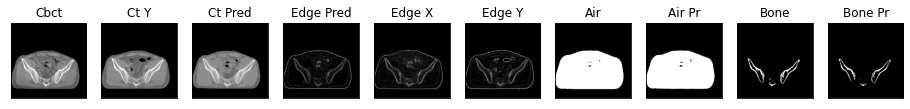

109it [00:51,  2.20it/s]

ssim score = 0.8122344613075256
psnr score = 22.681978225708008
snr score = 14.37928581237793
mae error = 0.030268510803580284
air dice score = 0.9930362945945023
bone dice score = 0.9054982817896479
contour dice score = 0.22291021049022675


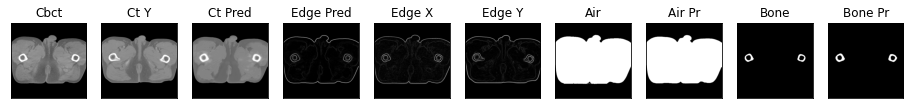

110it [00:52,  2.23it/s]

ssim score = 0.8033986687660217
psnr score = 22.31967544555664
snr score = 14.121271133422852
mae error = 0.032271724194288254
air dice score = 0.9931112031721648
bone dice score = 0.9078233927212026
contour dice score = 0.2216288447380066


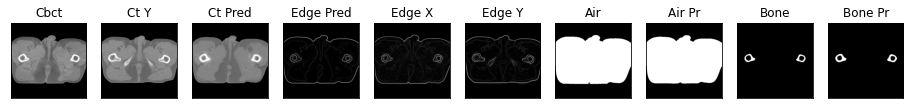

111it [00:52,  2.24it/s]

ssim score = 0.7940036654472351
psnr score = 21.935766220092773
snr score = 13.86531925201416
mae error = 0.035482924431562424
air dice score = 0.9930809114557261
bone dice score = 0.8908421913350196
contour dice score = 0.21633751690387726


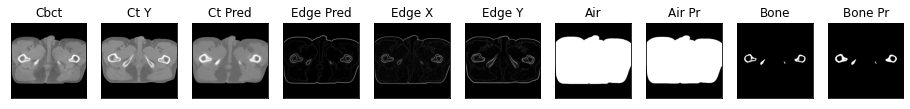

112it [00:53,  2.29it/s]

ssim score = 0.7849144339561462
psnr score = 21.619098663330078
snr score = 13.580940246582031
mae error = 0.036921847611665726
air dice score = 0.992762321705978
bone dice score = 0.9144634525674267
contour dice score = 0.2100045084953308


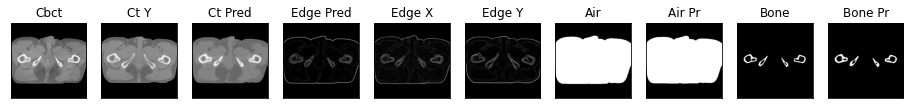

113it [00:53,  2.30it/s]

ssim score = 0.7773098349571228
psnr score = 21.528610229492188
snr score = 13.52069091796875
mae error = 0.03758801147341728
air dice score = 0.9926629413974498
bone dice score = 0.8876178698425163
contour dice score = 0.20895522832870483


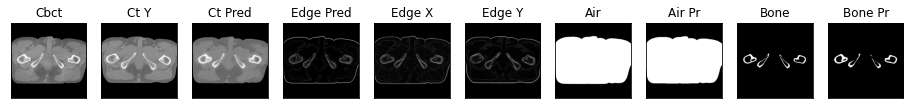

114it [00:53,  2.27it/s]

ssim score = 0.7711290717124939
psnr score = 21.396839141845703
snr score = 13.423338890075684
mae error = 0.0386880561709404
air dice score = 0.9928386711756557
bone dice score = 0.8993409227097163
contour dice score = 0.20561593770980835


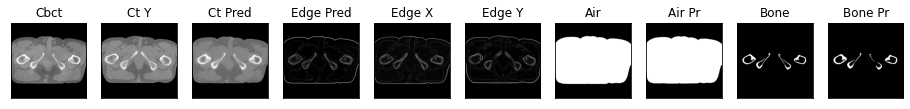

115it [00:54,  2.23it/s]

ssim score = 0.7620054483413696
psnr score = 21.061010360717773
snr score = 13.107818603515625
mae error = 0.040316395461559296
air dice score = 0.9927266793328169
bone dice score = 0.9187749667121334
contour dice score = 0.22934536635875702


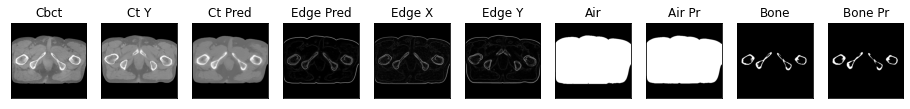

116it [00:54,  2.30it/s]

ssim score = 0.761921763420105
psnr score = 21.017759323120117
snr score = 13.103639602661133
mae error = 0.040289659053087234
air dice score = 0.9920438606191517
bone dice score = 0.9188684280768766
contour dice score = 0.24168913066387177


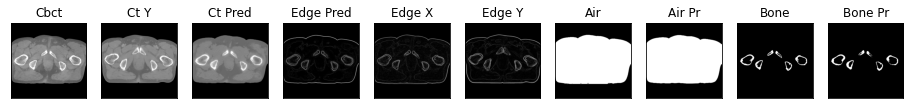

117it [00:55,  1.96it/s]

ssim score = 0.760810911655426
psnr score = 21.075214385986328
snr score = 13.209775924682617
mae error = 0.040547244250774384
air dice score = 0.9916142435652026
bone dice score = 0.9231779382807199
contour dice score = 0.23857204616069794


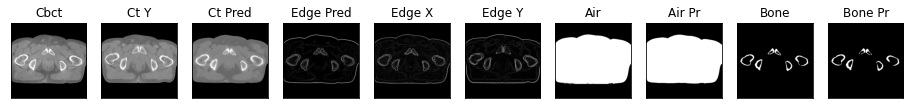

118it [00:55,  2.06it/s]

ssim score = 0.7477177381515503
psnr score = 20.7918643951416
snr score = 12.9490385055542
mae error = 0.04276876524090767
air dice score = 0.9914241496875741
bone dice score = 0.910330631674896
contour dice score = 0.23339012265205383


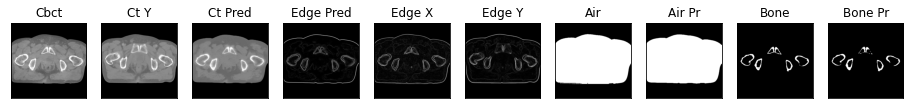

119it [00:56,  2.11it/s]

ssim score = 0.7350942492485046
psnr score = 20.788406372070312
snr score = 12.988357543945312
mae error = 0.04399716481566429
air dice score = 0.9923695128673848
bone dice score = 0.8947304071415243
contour dice score = 0.23454158008098602


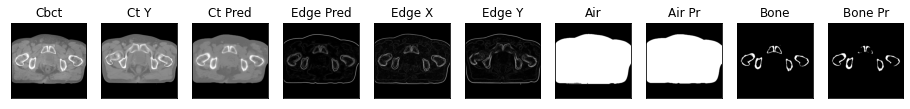

120it [00:56,  2.16it/s]

ssim score = 0.7351861596107483
psnr score = 20.819446563720703
snr score = 13.077735900878906
mae error = 0.04422931745648384
air dice score = 0.9921555923222037
bone dice score = 0.8892938496595751
contour dice score = 0.24818181991577148


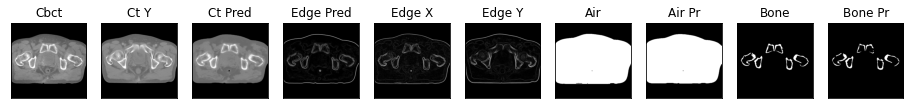

121it [00:57,  2.27it/s]

ssim score = 0.7310817241668701
psnr score = 20.726964950561523
snr score = 12.909880638122559
mae error = 0.04541940242052078
air dice score = 0.9924096587525986
bone dice score = 0.8430483592417632
contour dice score = 0.24760164320468903


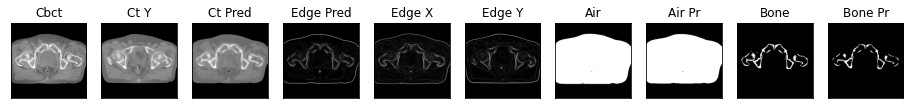

122it [00:57,  2.28it/s]

ssim score = 0.7343870401382446
psnr score = 20.724445343017578
snr score = 12.800145149230957
mae error = 0.04501276835799217
air dice score = 0.9924170616113788
bone dice score = 0.809399477808862
contour dice score = 0.24472960829734802


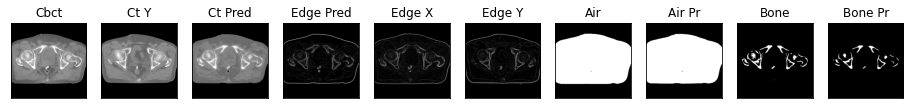

123it [00:58,  2.28it/s]

ssim score = 0.7465330958366394
psnr score = 21.096839904785156
snr score = 13.04945182800293
mae error = 0.042534198611974716
air dice score = 0.9927343406529879
bone dice score = 0.7910609676742127
contour dice score = 0.2409195452928543


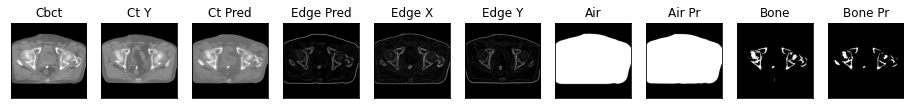

124it [00:58,  2.28it/s]

ssim score = 0.762311577796936
psnr score = 21.394065856933594
snr score = 13.234247207641602
mae error = 0.04003394767642021
air dice score = 0.9931177633600662
bone dice score = 0.8632799914094803
contour dice score = 0.22970479726791382


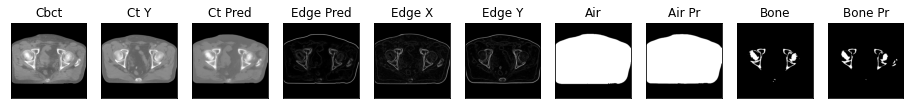

125it [00:58,  2.36it/s]

ssim score = 0.7645956873893738
psnr score = 21.62896728515625
snr score = 13.418502807617188
mae error = 0.03777497634291649
air dice score = 0.9932920236697436
bone dice score = 0.9100041858527627
contour dice score = 0.21325916051864624


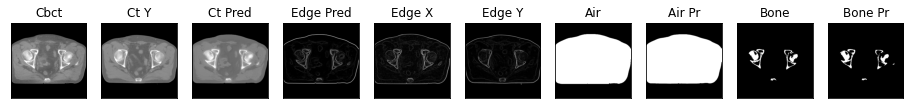

126it [00:59,  2.35it/s]

ssim score = 0.7629258036613464
psnr score = 21.399188995361328
snr score = 13.220874786376953
mae error = 0.03926177695393562
air dice score = 0.9935027820224233
bone dice score = 0.9051078819913573
contour dice score = 0.20214252173900604


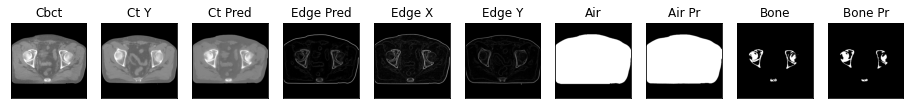

127it [01:00,  1.99it/s]

ssim score = 0.7572336792945862
psnr score = 21.111995697021484
snr score = 12.947160720825195
mae error = 0.04031781852245331
air dice score = 0.9930117447207375
bone dice score = 0.9135453474686271
contour dice score = 0.18360655009746552


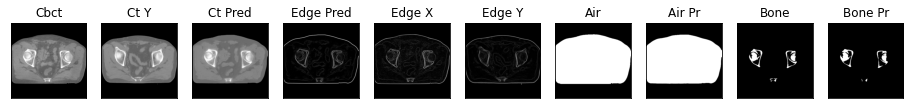

128it [01:00,  2.06it/s]

ssim score = 0.7590107917785645
psnr score = 20.763473510742188
snr score = 12.457147598266602
mae error = 0.04167373478412628
air dice score = 0.993065693430661
bone dice score = 0.9166964604943785
contour dice score = 0.1574728935956955


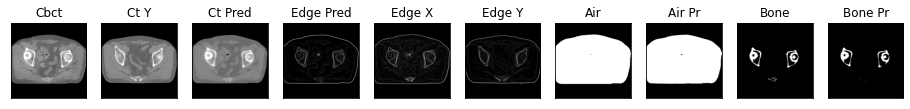

129it [01:00,  2.19it/s]

ssim score = 0.7648278474807739
psnr score = 20.900190353393555
snr score = 12.53455638885498
mae error = 0.040485769510269165
air dice score = 0.992838541666671
bone dice score = 0.9281707483933757
contour dice score = 0.1468498408794403


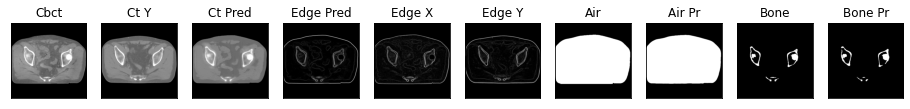

130it [01:01,  2.22it/s]

ssim score = 0.7636280655860901
psnr score = 21.328872680664062
snr score = 12.988887786865234
mae error = 0.03800800070166588
air dice score = 0.9927793110011462
bone dice score = 0.8894774011318948
contour dice score = 0.14021790027618408


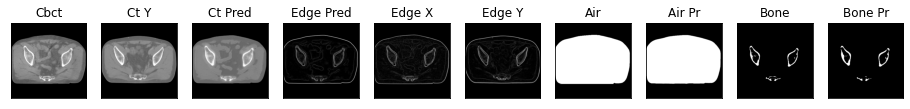

131it [01:01,  2.24it/s]

ssim score = 0.7617179155349731
psnr score = 21.155054092407227
snr score = 12.887882232666016
mae error = 0.038420792669057846
air dice score = 0.9925562763445084
bone dice score = 0.9079057329114507
contour dice score = 0.12713472545146942


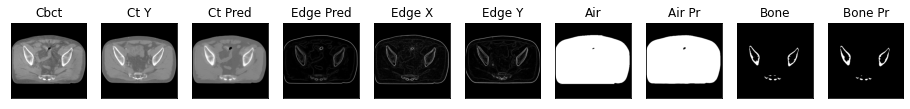

132it [01:02,  2.26it/s]

ssim score = 0.7544227242469788
psnr score = 20.707408905029297
snr score = 12.569466590881348
mae error = 0.041148800402879715
air dice score = 0.992431625937027
bone dice score = 0.9110410094651256
contour dice score = 0.11944577097892761


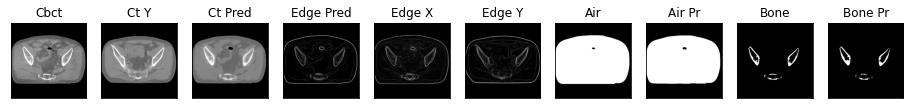

133it [01:02,  2.34it/s]

ssim score = 0.7475695013999939
psnr score = 20.496864318847656
snr score = 12.392881393432617
mae error = 0.04232381656765938
air dice score = 0.9925160478440576
bone dice score = 0.904861318223906
contour dice score = 0.11634615063667297


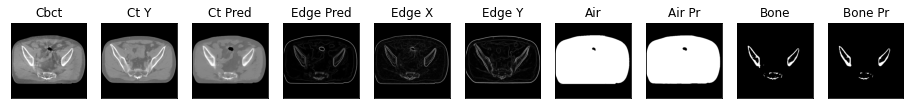

134it [01:02,  2.34it/s]

ssim score = 0.739227831363678
psnr score = 20.55885124206543
snr score = 12.425079345703125
mae error = 0.04296281933784485
air dice score = 0.9924770976157299
bone dice score = 0.8927894936242861
contour dice score = 0.106075219810009


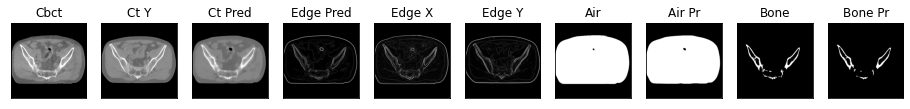

135it [01:03,  2.32it/s]

ssim score = 0.7384962439537048
psnr score = 21.009307861328125
snr score = 12.812158584594727
mae error = 0.04066045954823494
air dice score = 0.9928247573258724
bone dice score = 0.8730853391702259
contour dice score = 0.10159651935100555


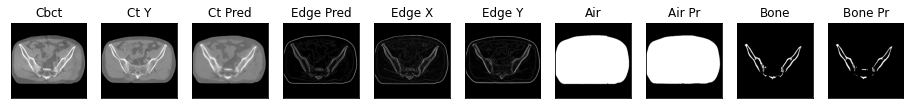

136it [01:03,  2.40it/s]

ssim score = 0.820332944393158
psnr score = 22.729801177978516
snr score = 14.207192420959473
mae error = 0.027942005544900894
air dice score = 0.9942625515997837
bone dice score = 0.847170809097737
contour dice score = 0.21529175341129303


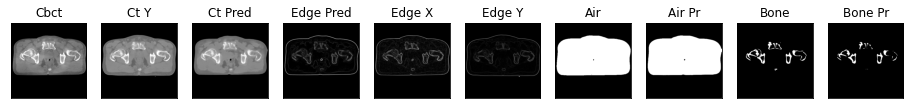

137it [01:04,  2.01it/s]

ssim score = 0.8220210075378418
psnr score = 22.69702911376953
snr score = 14.214433670043945
mae error = 0.027738401666283607
air dice score = 0.9940241424644481
bone dice score = 0.8463656387686348
contour dice score = 0.2181818187236786


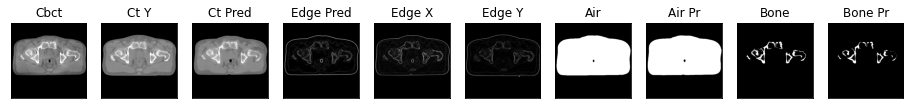

138it [01:04,  2.09it/s]

ssim score = 0.8238897323608398
psnr score = 22.817840576171875
snr score = 14.34303092956543
mae error = 0.027892792597413063
air dice score = 0.9941473259334049
bone dice score = 0.8263333817784285
contour dice score = 0.2200811356306076


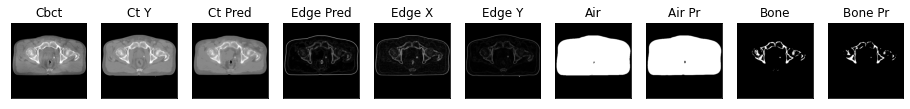

139it [01:05,  2.14it/s]

ssim score = 0.8281453251838684
psnr score = 22.802814483642578
snr score = 14.269586563110352
mae error = 0.02746109664440155
air dice score = 0.9943996701278297
bone dice score = 0.8420206351354412
contour dice score = 0.23272357881069183


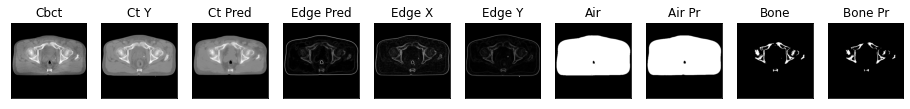

140it [01:05,  2.25it/s]

ssim score = 0.8332786560058594
psnr score = 22.952348709106445
snr score = 14.263494491577148
mae error = 0.02534666657447815
air dice score = 0.9943596299917317
bone dice score = 0.8786825804520519
contour dice score = 0.2388973981142044


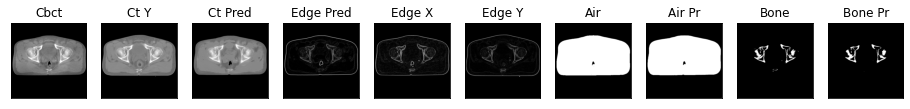

141it [01:06,  2.28it/s]

ssim score = 0.8366129994392395
psnr score = 23.085315704345703
snr score = 14.37565803527832
mae error = 0.024809904396533966
air dice score = 0.9943607605434218
bone dice score = 0.8968571428586163
contour dice score = 0.24654731154441833


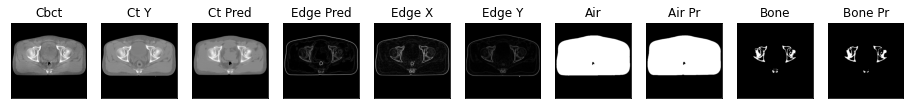

142it [01:06,  2.29it/s]

ssim score = 0.8371027708053589
psnr score = 23.07839584350586
snr score = 14.353109359741211
mae error = 0.024594400078058243
air dice score = 0.9944423860689187
bone dice score = 0.9067868206152241
contour dice score = 0.26091423630714417


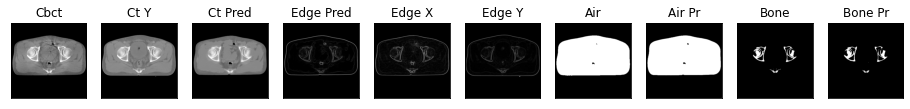

143it [01:07,  2.29it/s]

ssim score = 0.8333635330200195
psnr score = 22.52701187133789
snr score = 13.811090469360352
mae error = 0.025966884568333626
air dice score = 0.9943804866194873
bone dice score = 0.8878652655838799
contour dice score = 0.2969072163105011


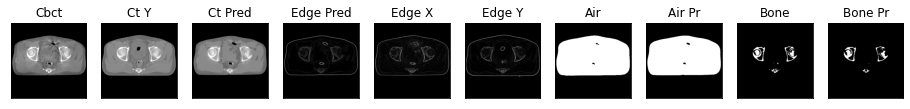

144it [01:07,  2.37it/s]

ssim score = 0.8267673254013062
psnr score = 22.537845611572266
snr score = 13.877704620361328
mae error = 0.02675601840019226
air dice score = 0.9943422053231982
bone dice score = 0.9106011544430438
contour dice score = 0.28053829073905945


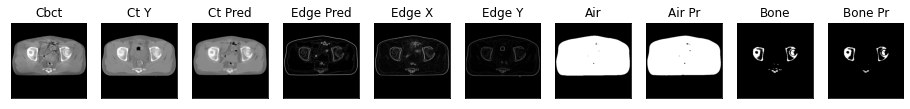

145it [01:07,  2.30it/s]

ssim score = 0.8265363574028015
psnr score = 22.238914489746094
snr score = 13.556842803955078
mae error = 0.02789253368973732
air dice score = 0.9939695957565566
bone dice score = 0.9181752353378976
contour dice score = 0.2858627736568451


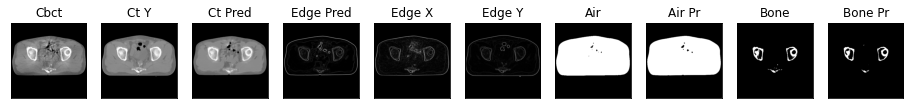

146it [01:08,  2.30it/s]

ssim score = 0.8256998062133789
psnr score = 21.71269989013672
snr score = 12.959853172302246
mae error = 0.028597699478268623
air dice score = 0.9939175455417113
bone dice score = 0.894959349595204
contour dice score = 0.2955613434314728


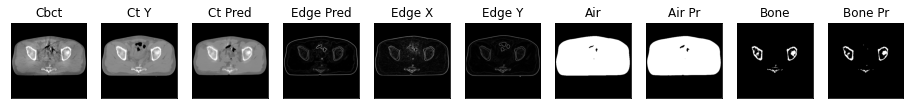

147it [01:09,  1.97it/s]

ssim score = 0.8250601291656494
psnr score = 21.95029067993164
snr score = 13.153552055358887
mae error = 0.02783062681555748
air dice score = 0.9937983544148395
bone dice score = 0.899032750722908
contour dice score = 0.3147953748703003


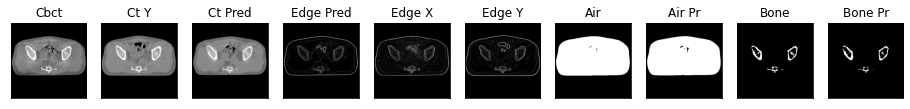

148it [01:09,  2.07it/s]

ssim score = 0.8273048400878906
psnr score = 22.160755157470703
snr score = 13.362918853759766
mae error = 0.026990417391061783
air dice score = 0.9942699588730963
bone dice score = 0.9077150847193993
contour dice score = 0.32016849517822266


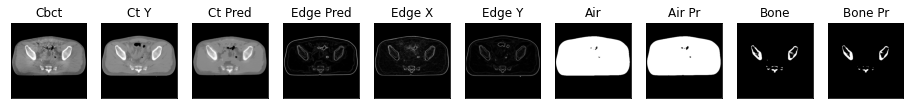

149it [01:09,  2.16it/s]

ssim score = 0.8209471702575684
psnr score = 22.136104583740234
snr score = 13.3516263961792
mae error = 0.027504712343215942
air dice score = 0.9932271872315116
bone dice score = 0.9096366508703059
contour dice score = 0.3134564757347107


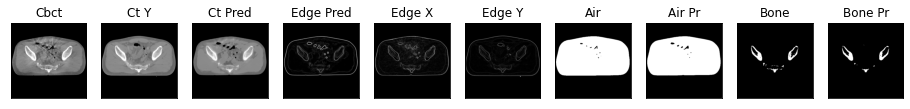

150it [01:10,  2.20it/s]

ssim score = 0.8171270489692688
psnr score = 22.012340545654297
snr score = 13.283066749572754
mae error = 0.028494928032159805
air dice score = 0.9932829554995855
bone dice score = 0.8957171991856463
contour dice score = 0.3046007454395294


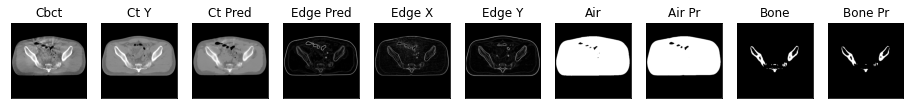

151it [01:10,  2.23it/s]

ssim score = 0.8204620480537415
psnr score = 21.646032333374023
snr score = 12.936128616333008
mae error = 0.029379989951848984
air dice score = 0.9927218888802364
bone dice score = 0.8663620788140154
contour dice score = 0.29978814721107483


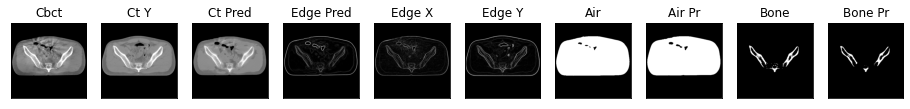

152it [01:11,  2.24it/s]

ssim score = 0.8248709440231323
psnr score = 21.79458999633789
snr score = 13.029948234558105
mae error = 0.028668807819485664
air dice score = 0.9925501521886418
bone dice score = 0.8570979405776278
contour dice score = 0.24335813522338867


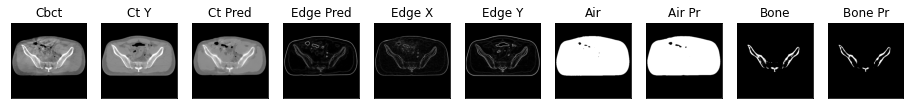

153it [01:11,  2.32it/s]

ssim score = 0.8252348899841309
psnr score = 22.041223526000977
snr score = 13.240228652954102
mae error = 0.027925381436944008
air dice score = 0.992967388598462
bone dice score = 0.8396995365216605
contour dice score = 0.26588359475135803


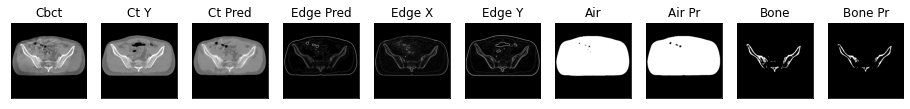

154it [01:11,  2.32it/s]

ssim score = 0.8261531591415405
psnr score = 22.17670249938965
snr score = 13.375778198242188
mae error = 0.027128571644425392
air dice score = 0.9934313954393389
bone dice score = 0.8128042484169817
contour dice score = 0.2390139400959015


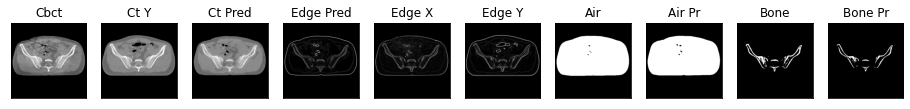

155it [01:12,  2.31it/s]

ssim score = 0.8266372084617615
psnr score = 22.340469360351562
snr score = 13.538122177124023
mae error = 0.026845397427678108
air dice score = 0.9934283865636672
bone dice score = 0.8149688149715627
contour dice score = 0.23288409411907196


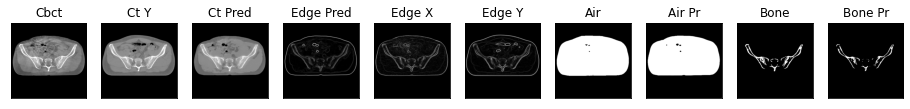

156it [01:12,  2.28it/s]

ssim score = 0.817740797996521
psnr score = 21.759933471679688
snr score = 12.962626457214355
mae error = 0.02874254807829857
air dice score = 0.992046593186379
bone dice score = 0.8015140045450188
contour dice score = 0.24295011162757874


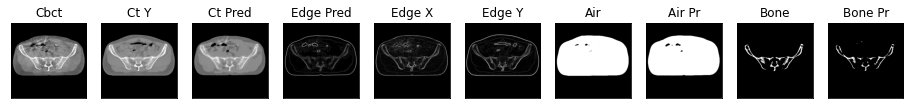

157it [01:13,  1.99it/s]

ssim score = 0.8086115717887878
psnr score = 21.267139434814453
snr score = 12.452560424804688
mae error = 0.030606653541326523
air dice score = 0.9913375976585618
bone dice score = 0.7801265236880092
contour dice score = 0.2464558333158493


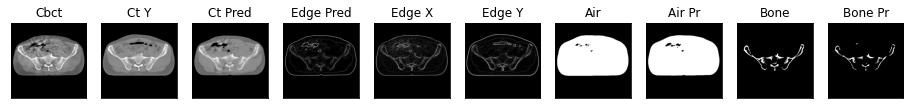

158it [01:13,  2.08it/s]

ssim score = 0.8033599257469177
psnr score = 21.112625122070312
snr score = 12.279420852661133
mae error = 0.031541790813207626
air dice score = 0.9918922546163688
bone dice score = 0.7543651968074229
contour dice score = 0.27677100896835327


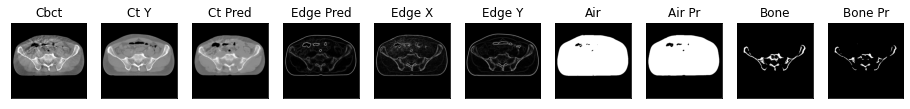

159it [01:14,  2.14it/s]

ssim score = 0.7976858615875244
psnr score = 20.799787521362305
snr score = 11.92064380645752
mae error = 0.03309435769915581
air dice score = 0.9917359300842319
bone dice score = 0.7439516129069131
contour dice score = 0.2729281783103943


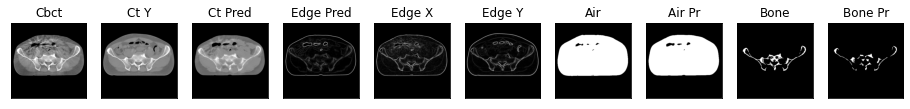

160it [01:14,  2.19it/s]

ssim score = 0.7929158806800842
psnr score = 20.781455993652344
snr score = 11.848515510559082
mae error = 0.0336507149040699
air dice score = 0.9913111284393519
bone dice score = 0.7724955215685201
contour dice score = 0.27000001072883606


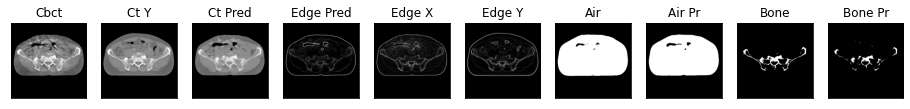

161it [01:15,  2.29it/s]

ssim score = 0.785875141620636
psnr score = 20.470745086669922
snr score = 11.568270683288574
mae error = 0.03538651019334793
air dice score = 0.9919357414327298
bone dice score = 0.8018494055508342
contour dice score = 0.30083566904067993


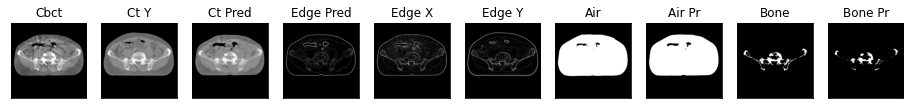

162it [01:15,  2.29it/s]

ssim score = 0.7813962697982788
psnr score = 20.26700210571289
snr score = 11.309300422668457
mae error = 0.03555174916982651
air dice score = 0.9921271182372489
bone dice score = 0.8047385620941621
contour dice score = 0.3130919337272644


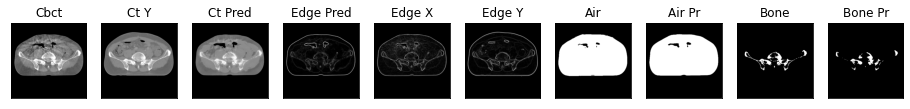

163it [01:16,  2.26it/s]

ssim score = 0.7933534979820251
psnr score = 20.99513816833496
snr score = 11.889902114868164
mae error = 0.03204568102955818
air dice score = 0.9927892887725842
bone dice score = 0.8348239239821852
contour dice score = 0.2529378831386566


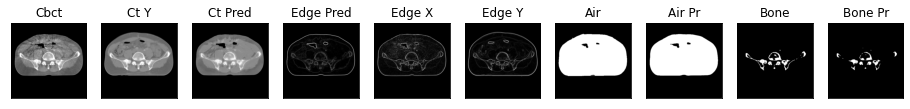

164it [01:16,  2.26it/s]

ssim score = 0.8371372222900391
psnr score = 24.21781349182129
snr score = 14.598726272583008
mae error = 0.025253845378756523
air dice score = 0.9932139100028202
bone dice score = 0.8919119465769995
contour dice score = 0.2697719633579254


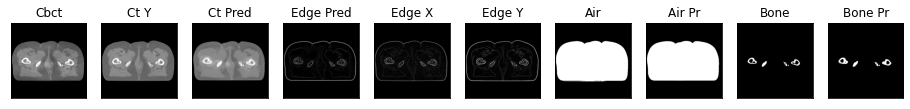

165it [01:17,  2.25it/s]

ssim score = 0.8372659087181091
psnr score = 24.512672424316406
snr score = 15.014596939086914
mae error = 0.024106791242957115
air dice score = 0.9929048782642028
bone dice score = 0.8979591836756387
contour dice score = 0.27906978130340576


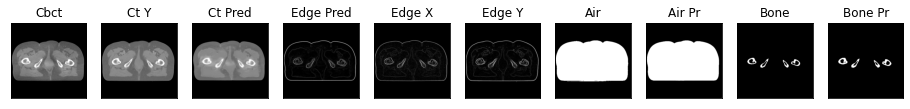

166it [01:17,  2.28it/s]

ssim score = 0.832147479057312
psnr score = 24.54888916015625
snr score = 15.133728981018066
mae error = 0.024063292890787125
air dice score = 0.9927881802223575
bone dice score = 0.887870105064224
contour dice score = 0.22396087646484375


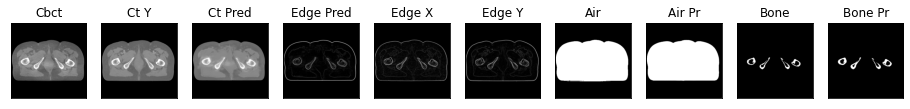

167it [01:18,  1.96it/s]

ssim score = 0.828490138053894
psnr score = 24.525968551635742
snr score = 15.174257278442383
mae error = 0.024100979790091515
air dice score = 0.9929103825773068
bone dice score = 0.8965160400155827
contour dice score = 0.22689487040042877


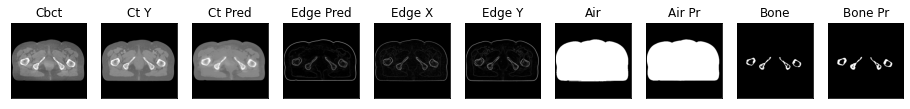

168it [01:18,  2.05it/s]

ssim score = 0.8272808194160461
psnr score = 24.418193817138672
snr score = 15.094942092895508
mae error = 0.02434377186000347
air dice score = 0.9930075002538822
bone dice score = 0.9180658159852575
contour dice score = 0.22955664992332458


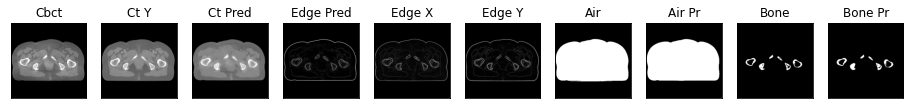

169it [01:18,  2.11it/s]

ssim score = 0.8291261792182922
psnr score = 24.370933532714844
snr score = 15.070637702941895
mae error = 0.024250175803899765
air dice score = 0.9927272464124753
bone dice score = 0.92071881606905
contour dice score = 0.2163742631673813


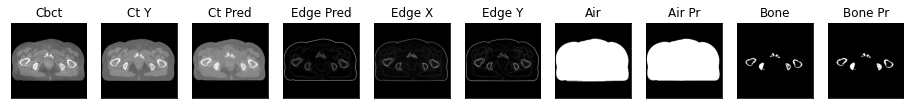

170it [01:19,  2.20it/s]

ssim score = 0.8242546916007996
psnr score = 24.265731811523438
snr score = 14.9967622756958
mae error = 0.024542246013879776
air dice score = 0.9925626399018034
bone dice score = 0.9154660649207522
contour dice score = 0.19854721426963806


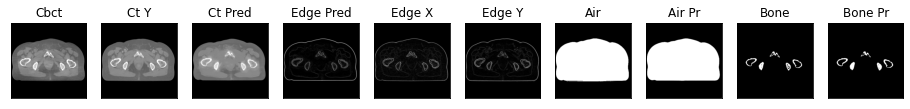

171it [01:19,  2.24it/s]

ssim score = 0.8232879042625427
psnr score = 24.02611541748047
snr score = 14.805508613586426
mae error = 0.024932043626904488
air dice score = 0.9922742322924162
bone dice score = 0.9119972499155724
contour dice score = 0.18917647004127502


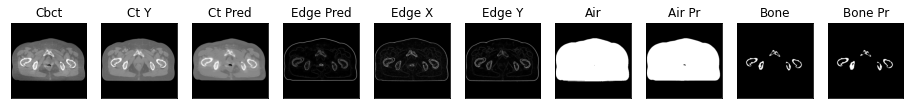

172it [01:20,  2.26it/s]

ssim score = 0.8230758309364319
psnr score = 23.91473388671875
snr score = 14.736871719360352
mae error = 0.02456093765795231
air dice score = 0.9923718110634053
bone dice score = 0.9142950605182484
contour dice score = 0.21346153318881989


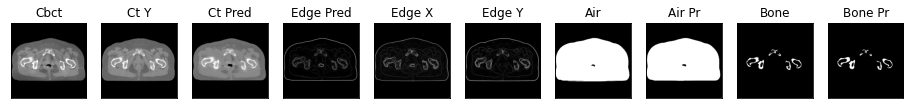

173it [01:20,  2.27it/s]

ssim score = 0.821907639503479
psnr score = 23.89713478088379
snr score = 14.806975364685059
mae error = 0.024215102195739746
air dice score = 0.9921755449689676
bone dice score = 0.8963093145885134
contour dice score = 0.20924802124500275


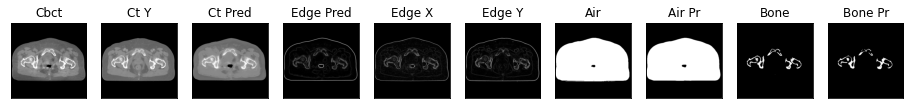

174it [01:21,  2.35it/s]

ssim score = 0.8275620937347412
psnr score = 24.702451705932617
snr score = 15.725564956665039
mae error = 0.022841647267341614
air dice score = 0.9922350321445302
bone dice score = 0.8918544630505872
contour dice score = 0.19861431419849396


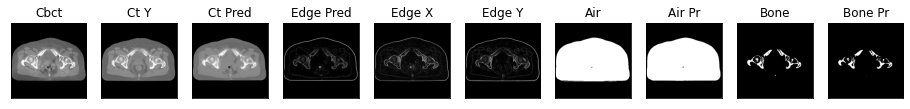

175it [01:21,  2.34it/s]

ssim score = 0.8313860893249512
psnr score = 24.03860092163086
snr score = 14.933161735534668
mae error = 0.023638298735022545
air dice score = 0.9918285948782988
bone dice score = 0.8885567181549816
contour dice score = 0.20157189667224884


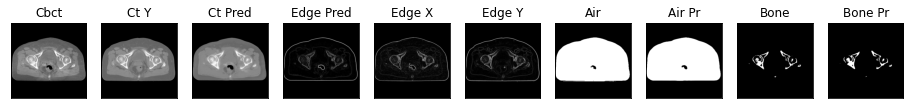

176it [01:21,  2.32it/s]

ssim score = 0.8318645358085632
psnr score = 24.049571990966797
snr score = 14.834711074829102
mae error = 0.02377033233642578
air dice score = 0.9920171451585121
bone dice score = 0.8742207554111804
contour dice score = 0.21608980000019073


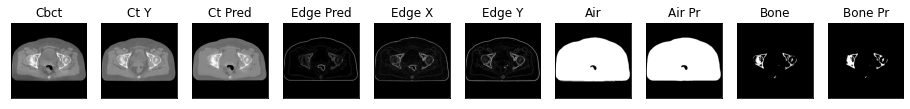

177it [01:22,  1.99it/s]

ssim score = 0.8379626870155334
psnr score = 24.051265716552734
snr score = 14.809279441833496
mae error = 0.02426126040518284
air dice score = 0.9925234582768883
bone dice score = 0.902628533643534
contour dice score = 0.2293577939271927


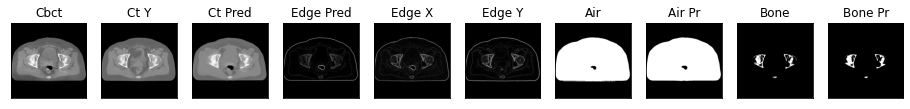

178it [01:23,  2.13it/s]

ssim score = 0.8413749933242798
psnr score = 24.534971237182617
snr score = 15.284978866577148
mae error = 0.02428722009062767
air dice score = 0.9926292371224935
bone dice score = 0.916001277548451
contour dice score = 0.24216923117637634


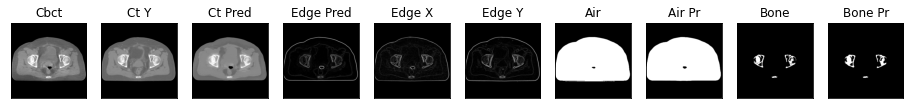

179it [01:23,  2.19it/s]

ssim score = 0.8406598567962646
psnr score = 25.128284454345703
snr score = 15.912521362304688
mae error = 0.02306864969432354
air dice score = 0.9931476460438796
bone dice score = 0.9220917822850725
contour dice score = 0.22159358859062195


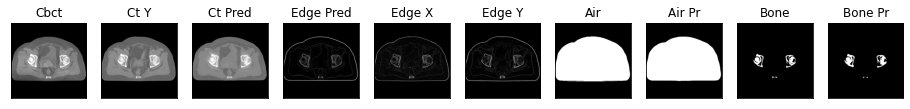

180it [01:23,  2.22it/s]

ssim score = 0.8324804306030273
psnr score = 24.821640014648438
snr score = 15.657367706298828
mae error = 0.02394992858171463
air dice score = 0.9936322650543504
bone dice score = 0.9318391157517372
contour dice score = 0.2041405886411667


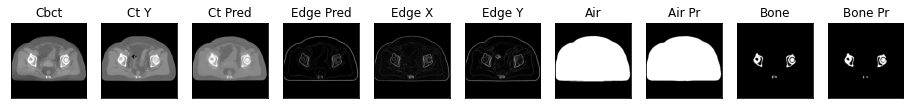

181it [01:24,  2.24it/s]

ssim score = 0.8199229836463928
psnr score = 24.075130462646484
snr score = 14.948417663574219
mae error = 0.025352176278829575
air dice score = 0.9938584816724936
bone dice score = 0.9298245614046702
contour dice score = 0.21200387179851532


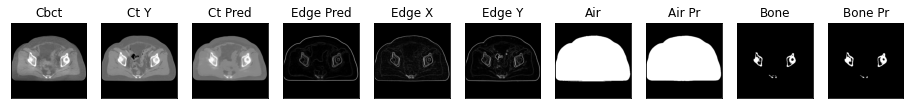

182it [01:24,  2.32it/s]

ssim score = 0.8057015538215637
psnr score = 22.627239227294922
snr score = 13.428088188171387
mae error = 0.028754476457834244
air dice score = 0.9930426045845911
bone dice score = 0.8737160120871357
contour dice score = 0.17932386696338654


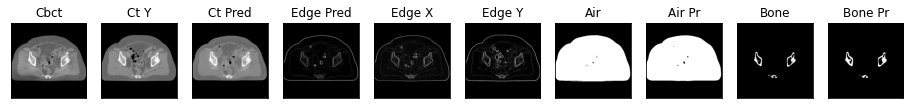

183it [01:25,  2.33it/s]

ssim score = 0.7991246581077576
psnr score = 22.26161003112793
snr score = 13.044466972351074
mae error = 0.03024105541408062
air dice score = 0.9928666292427175
bone dice score = 0.8935032894758737
contour dice score = 0.1850569099187851


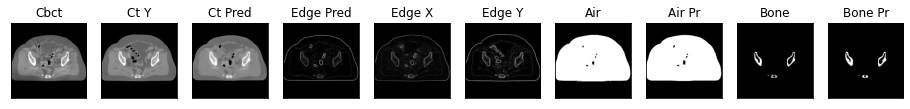

184it [01:25,  2.32it/s]

ssim score = 0.7991183996200562
psnr score = 22.824657440185547
snr score = 13.672428131103516
mae error = 0.02917645312845707
air dice score = 0.9928198875567346
bone dice score = 0.8987240829366283
contour dice score = 0.16815035045146942


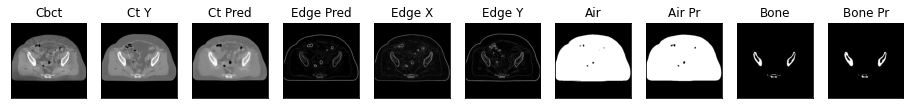

185it [01:26,  2.31it/s]

ssim score = 0.7989380359649658
psnr score = 23.004165649414062
snr score = 13.907028198242188
mae error = 0.029103219509124756
air dice score = 0.9925207793428541
bone dice score = 0.9148342059351687
contour dice score = 0.1733931303024292


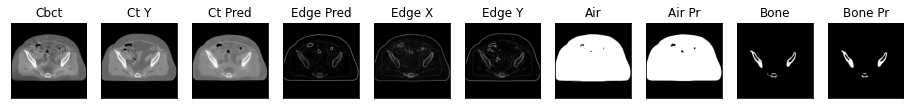

186it [01:26,  2.38it/s]

ssim score = 0.7929657101631165
psnr score = 22.36504554748535
snr score = 13.332340240478516
mae error = 0.03107159025967121
air dice score = 0.9927540085622406
bone dice score = 0.9044697633668644
contour dice score = 0.1819075644016266


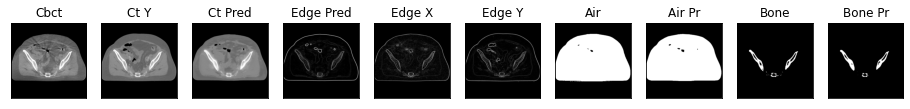

187it [01:27,  2.00it/s]

ssim score = 0.7937066555023193
psnr score = 22.24878692626953
snr score = 13.288941383361816
mae error = 0.031512197107076645
air dice score = 0.9925930811595207
bone dice score = 0.8976034858401742
contour dice score = 0.16863904893398285


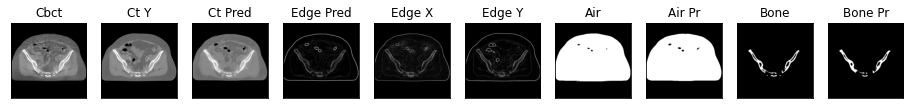

188it [01:27,  2.08it/s]

ssim score = 0.7913917899131775
psnr score = 22.215978622436523
snr score = 13.251840591430664
mae error = 0.03187914937734604
air dice score = 0.9923391449412893
bone dice score = 0.8828633405655794
contour dice score = 0.1399902105331421


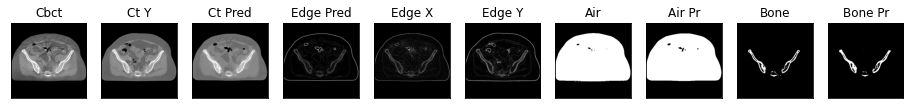

189it [01:27,  2.14it/s]

ssim score = 0.7911005616188049
psnr score = 22.263681411743164
snr score = 13.277368545532227
mae error = 0.032044801861047745
air dice score = 0.9930759315754406
bone dice score = 0.8879853095502626
contour dice score = 0.1544439047574997


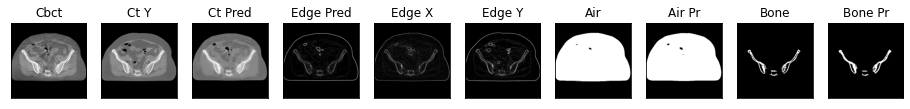

190it [01:28,  2.19it/s]

ssim score = 0.7982832193374634
psnr score = 22.851293563842773
snr score = 13.876614570617676
mae error = 0.03092089295387268
air dice score = 0.9929884939387759
bone dice score = 0.8908392759203121
contour dice score = 0.14196041226387024


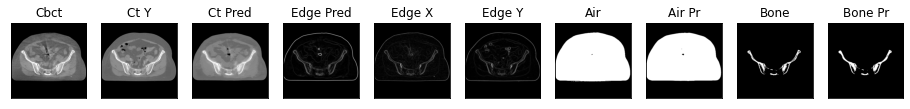

191it [01:28,  2.15it/s]


In [45]:
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=4)
test_epoch(model, testloader, device, True, os.path.join("eval-gan", wandb.run.name))

In [46]:
tf_discriminator = Discriminator(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)
replace_relu_to_leakyReLU(tf_discriminator)
replace_bn_to_instanceNorm(tf_discriminator)
tf_discriminator.load_state_dict(checkpoint["tf_discriminator"])

<All keys matched successfully>

In [47]:
edge_discriminator = Discriminator(in_channel=E_IN_CHANNELS, n_classes=E_N_CLASSES, activation=E_ACT)
replace_relu_to_leakyReLU(edge_discriminator)
replace_bn_to_instanceNorm(edge_discriminator)
edge_discriminator.load_state_dict(checkpoint["edge_discriminator"])

<All keys matched successfully>

In [48]:
# score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, \
#             score_air_test, score_bone_test, score_cont_test, score_tf_acc_test, score_edge_acc_test
eval_epoch(model, tf_discriminator, edge_discriminator, testloader, device)

191it [00:20,  9.26it/s]


(0.8244319146216228,
 23.285529121678536,
 14.289801113268467,
 0.0272889107036653,
 0.9932044255870311,
 0.8843926486294668,
 0.3030672562137948,
 0.49109947643979057,
 0.48324607329842934)

In [49]:
# import torchvision.models as models
# models.vgg16(pretrained=True)